# Spotify Tracks Dataset
__Aprendizaje Automático Avanzado (AAA)__

_Alan García Justel_

Para el desarrollo de esta práctica, se ha elegido el dataset [Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset), el cual contiene información de $114$ géneros de música distintos. Este dataset puede ser utilizado para desarrollar aplicaciones de recomentación, clasificación de canciones o ingluso de predicción de popularidad.

En este notebook se explorará cómo emplear las **features descriptivas** para realizar clasificaciones en base al género de las canciones. Estas features son de tipo tabular y han sido recopiladas mediante diferentes métodos, los cuales se detallarán más adelante. No se hará uso de las pistas de audio en sí, ya que para ello serían necesarias técnicas de procesamiento de series temporales que escapan al alcance de esta asignatura. Por lo tanto, el objetivo principal de este cuaderno es desarrollar un sistema de clasificación basado en características previamente anotadas de las canciones.

Además, con el fin de acotar el problema, se ha decidido restringir el análisis a un problema de clasificación binaria, enfocándose en canciones pertenecientes a géneros musicales que caracterizan al **metal**. Los géneros musicales considerados como metal en este estudio son los siguientes:  

- black-metal  
- death-metal  
- grindcore  
- heavy-metal  
- industrial  
- metalcore  
- metal  

# Setup

In [27]:
import pandas as pd
import numpy as np
import math

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, roc_curve, roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import zscore, wilcoxon
from scipy.spatial.distance import pdist, squareform

from statsmodels.stats.contingency_tables import mcnemar

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from matplotlib.axes import Axes 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from typing import List

from contextlib import contextmanager
import warnings
import joblib
import sys
import os
import io

In [29]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [19]:
metal_genres = ['black-metal', 'death-metal', 'grindcore', 'heavy-metal', 'industrial', 'metalcore', 'metal']

# Dataset Exploration

El dataset se proporciona en un archivo **.csv**, por lo que se ha optado por utilizar la librería `pandas` para cargar y manipular los datos, así como para realizar una exploración inicial de las variables disponibles. El dataset contiene **114,000 instancias** y **21 características**, que describen diversas propiedades de las canciones. A continuación, se detallan las características más relevantes:

- **Unamed0**: Identificador único asignado a cada instancia por los creadores del dataset.
- **track_id**: Identificador único del track, que permite acceder a la secuencia de audio de la canción.
- **artists**: Nombre o nombres de los artistas de la canción. Si hay varios artistas, estos se separan por `;`.
- **album_name**: Nombre del álbum al que pertenece la canción.
- **track_name**: Nombre de la canción.
- **popularity**: Popularidad de la canción, medida en una escala de 0 a 100, donde 100 es la más popular. Este valor se calcula mediante un algoritmo que considera el número total de reproducciones y su frecuencia reciente. Canciones con muchas reproducciones actuales tendrán una popularidad más alta que aquellas que fueron populares en el pasado.
- **duration_ms**: Duración de la canción en milisegundos.
- **explicit**: Indica si la canción contiene letras explícitas (`true` = sí, `false` = no o desconocido).
- **danceability**: Mide qué tan adecuada es una canción para bailar, basándose en elementos como el tempo, la estabilidad del ritmo y la fuerza del beat. El valor varía de 0.0 (menos bailable) a 1.0 (más bailable).
- **energy**: Mide la intensidad y actividad de la canción en una escala de 0.0 a 1.0. Canciones con alta energía suelen ser rápidas, fuertes y ruidosas (por ejemplo, el death metal), mientras que las de baja energía son más suaves (por ejemplo, un preludio de Bach).
- **key**: La tonalidad de la canción, representada como un número entero que sigue la notación estándar de clases de tono. Por ejemplo, 0 = Do (C), 1 = Do♯/Re♭ (C♯/D♭), 2 = Re (D), etc. Si no se detecta tonalidad, el valor es -1.
- **loudness**: El volumen general de la canción en decibelios (dB).
- **mode**: Indica la modalidad de la canción: mayor (1) o menor (0).
- **speechiness**: Detecta la presencia de palabras habladas en la canción. Valores cercanos a 1.0 indican que la canción es principalmente hablada (por ejemplo, un audiolibro), mientras que valores entre 0.33 y 0.66 sugieren una mezcla de música y habla (por ejemplo, rap). Valores por debajo de 0.33 indican que la canción es principalmente música.
- **acousticness**: Mide la confianza de que la canción sea acústica, en una escala de 0.0 a 1.0. Un valor de 1.0 indica alta confianza en que la canción es acústica.
- **instrumentalness**: Predice si la canción contiene vocales. Valores cercanos a 1.0 indican que es probable que la canción no tenga contenido vocal.
- **liveness**: Detecta la presencia de una audiencia en la grabación. Valores altos (por encima de 0.8) sugieren que la canción fue grabada en vivo.
- **valence**: Mide la positividad musical de la canción en una escala de 0.0 a 1.0. Canciones con alta valencia suenan más positivas (felices, alegres), mientras que las de baja valencia suenan más negativas (tristes, deprimentes).
- **tempo**: El tempo estimado de la canción en pulsaciones por minuto (BPM).
- **time_signature**: Indica cuántos pulsos hay en cada compás. Los valores van de 3 a 7, representando firmas de tiempo como 3/4, 4/4, etc.
- **track_genre**: El género musical al que pertenece la canción.

In [3]:
df = pd.read_csv('../../data/AAA/spotify_tracks.csv')
print(f"data_frame shape: {df.shape}")
df.head()

data_frame shape: (114000, 21)


Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  ...  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610  ...    -6.746     0       0.1430        0.0322   
1         0.420  0.1660  ...   -17.235     1       0.0763        0.9240   
2         0.438  0.3590  ...    -9.734     1       0.0557        0.2100   
3         0.266  0.0596  ...   -18.515     1       0.0363        0.9050   
4         0.618  0.4430  ...    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature  track_genre  
0          0.000001    0.3580    0.715   87.917               4     acoustic  
1          0.000006    0.1010    0.267   77.489               4     acoustic  
2          0.000000    0.1170    0.120   76.332               4     acoustic  
3          0.000071    0.1320    0.143  181.740               3     acoustic  
4          0.000000    0.0829    0.167  119.949               4     acoustic  

[5 rows x 21 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [4]:
df.describe()

Unnamed: 0     popularity   duration_ms   danceability  \
count  114000.000000  114000.000000  1.140000e+05  114000.000000   
mean    56999.500000      33.238535  2.280292e+05       0.566800   
std     32909.109681      22.305078  1.072977e+05       0.173542   
min         0.000000       0.000000  0.000000e+00       0.000000   
25%     28499.750000      17.000000  1.740660e+05       0.456000   
50%     56999.500000      35.000000  2.129060e+05       0.580000   
75%     85499.250000      50.000000  2.615060e+05       0.695000   
max    113999.000000     100.000000  5.237295e+06       0.985000   

              energy            key       loudness           mode  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean        0.641383       5.309140      -8.258960       0.637553   
std         0.251529       3.559987       5.029337       0.480709   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000       2.000000     -10.013000       0.000000   
50%         0.685000       5.000000      -7.004000       1.000000   
75%         0.854000       8.000000      -5.003000       1.000000   
max         1.000000      11.000000       4.532000       1.000000   

         speechiness   acousticness  instrumentalness       liveness  \
count  114000.000000  114000.000000     114000.000000  114000.000000   
mean        0.084652       0.314910          0.156050       0.213553   
std         0.105732       0.332523          0.309555       0.190378   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.035900       0.016900          0.000000       0.098000   
50%         0.048900       0.169000          0.000042       0.132000   
75%         0.084500       0.598000          0.049000       0.273000   
max         0.965000       0.996000          1.000000       1.000000   

             valence          tempo  time_signature  
count  114000.000000  114000.000000   114000.000000  
mean        0.474068     122.147837        3.904035  
std         0.259261      29.978197        0.432621  
min         0.000000       0.000000        0.000000  
25%         0.260000      99.218750        4.000000  
50%         0.464000     122.017000        4.000000  
75%         0.683000     140.071000        4.000000  
max         0.995000     243.372000        5.000000

Al encontrarnos con estos datos surgen varias cuestiones:

- **Distribución de géneros musicales**: ¿Cómo se distribuye el número de instancias de cada género musical? ¿Está el dataset balanceado o hay desequilibrios entre géneros?
- **Valores faltantes**: ¿Hay missing values en el dataset? De ser así, ¿cómo los tratamos?
- **Entradas duplicadas**: ¿Hay filas duplicadas? De ser así, ¿qué hacemos con ellas?
- **Tipos de datos**: ¿Qué tipos de datos hay? ¿Variables continuas, discretas, binarias o categóricas?
- **Escalado de datos**: ¿Es necesario escalar los datos para que todas las variables contribuyan equitativamente en los modelos?
- **Correlación entre géneros**: ¿Cómo de correlacionados están los distintos géneros musicales?
- **Relación entre variables y géneros**: ¿Qué relación existe entre las variables descriptivas, como la _energía_, y los géneros musicales de las canciones?

Por esta razón, se va a realizar un **estudio exploratorio de los datos** con los siguientes objetivos:

1. Detectar y tratar valores faltantes y entradas duplicadas.
2. Preprocesar los datos, incluyendo la normalización o estandarización de variables.
3. Estudiar las correlaciones entre las features y las relaciones entre los géneros musicales.
4. Visualizar los datos y sus distribuciones.
5. Identificar outliers.

## 1 - Valores faltantes

Existe una instancia del dataset que tiene todos los datos exceptuando aquellos relacionados con los nombres del artista, el álbum y el nombre de la canción. Sin embargo, sí que contamos con el _track_id_ de la canción, por lo que podemos hacer una consulta rápida mediante la _API_ de spotify para recuperar los datos faltantes de la canción.

In [6]:
exist_missing_values = False
for i, is_null in enumerate(df.isnull().sum()):
    if is_null:
        exist_missing_values = True
        print(f"La variable '{df.columns[i]}' presenta {is_null} missing values")

df[df.isnull().any(axis=1)]

La variable 'artists' presenta 1 missing values
La variable 'album_name' presenta 1 missing values
La variable 'track_name' presenta 1 missing values


Unnamed: 0                track_id artists album_name track_name  \
65900       65900  1kR4gIb7nGxHPI3D2ifs59     NaN        NaN        NaN   

       popularity  duration_ms  explicit  danceability  energy  ...  loudness  \
65900           0            0     False         0.501   0.583  ...     -9.46   

       mode  speechiness  acousticness  instrumentalness  liveness  valence  \
65900     0       0.0605          0.69           0.00396    0.0747    0.734   

         tempo  time_signature  track_genre  
65900  138.391               4        k-pop  

[1 rows x 21 columns]

In [7]:
def buscar_datos_cancion(track_id:str):
    """
    Se ha de contar con las variables de entorno SPOTIFY_CLIENT_ID y 
    SPOTIFY_CLIENT_SECRET de Spotify Developers para poder acceder 
    a la API de Spotify.
    """
    import spotipy
    from spotipy.oauth2 import SpotifyClientCredentials

    # Configura tus credenciales
    CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID")
    CLIENT_SECRET = os.getenv("SPOTIFY_CLIENT_SECRET")
    if not CLIENT_ID or not CLIENT_SECRET:
        raise ValueError("Asegúrate de que las variables de entorno SPOTIFY_CLIENT_ID y SPOTIFY_CLIENT_SECRET están configuradas.")

    # Autenticación
    auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
    sp = spotipy.Spotify(auth_manager=auth_manager)

    # Imprimir el nombre de la canción y el artista
    track_info = sp.track(track_id)
    print(f"Nombre de la canción: {track_info['name']}")
    print(f"Artista: {'; '.join(artist['name'] for artist in track_info['artists'])}")

buscar_datos_cancion(track_id="1kR4gIb7nGxHPI3D2ifs59")

Nombre de la canción: 
Artista: 


In [7]:
duplicates = df.duplicated().sum()
print(f"Existen {duplicates} instancias duplicadas.")

Existen 0 instancias duplicadas.


Sin embargo, al realizar una consulta a la **API de Spotify**, se observa que los datos de la canción en cuestión siguen estando omitidos. Dado que este caso es aislado y los datos faltantes no afectan a las **features** utilizadas en el entrenamiento de los modelos (sólo es información útil para identificar la canción), se ha decidido ignorar este caso.

Por otro lado, no se han encontrado entradas duplicadas.

In [ ]:
counts = df['track_genre'].value_counts()
print(f"El dataset presenta {len(counts)} géneros musicales distintos.")

distinc_nums = []
for c in counts:
    if c not in distinc_nums:
        distinc_nums.append(c)

if len(distinc_nums) == 1:
    print(f"Cada género musical tiene {distinc_nums[0]} instancias.")
else:
    print(f"Hay géneros con estos números de instancias: {distinc_nums}.")

El dataset presenta 114 géneros musicales distintos.
El dataset está balanceado y cada género musical tiene 1000 instancias.


## 2 - Preprocesar los datos

Como se ha visto, hay varias variables que únicamente aportan información para la identificación de las pistas de audio. Por ello, las variables `"Unnamed: 0"`, `"track_id"`, `"artists"`, `"album_name"` y `"track_name"` no se van a tener en cuenta.

Por otro lado, el dataset presenta $3$ tipos de variables que se van a tratar de forma distinta:

- Nominales: `"time_signature"` y `"key"`. Toman valores numéricos, pero indican categorías. Se va a realizar un 'One-Hot-Encoding' de estas variables.
- Binarias: `"mode"` y `"explicit"`. No se van a tratar
- Numéricas: todas las demás. Se van a escalar.

Además, los géneros musicales se presentan es strings, por lo que es interesante codificarlos (sobre todo para que los nombres no ocupen mucho a la hora de graficar).

In [4]:
# One-Hot-Encoding de la variable 'time_signature' 
df = pd.get_dummies(df, columns=['time_signature'], prefix='ts')
df = pd.get_dummies(df, columns=['key'], prefix='k')

# Codificar la variable 'track_genre' para análisis
LE = LabelEncoder()
df["track_genre_encoded"] = LE.fit_transform(df["track_genre"])
non_feature_columns = ["Unnamed: 0", "track_id", "artists", "album_name", "track_name", "track_genre", "track_genre_encoded"]

In [5]:
# Estandarizar los datos
scaler = StandardScaler()
non_scaling_features = [ 'ts_0', 'ts_1', 'ts_3', 'ts_3', 'ts_5', 'k_0', 'k_1', 'k_2', 'k_3', 'k_4', 'k_5', 'k_6', 'k_7', 'k_8', 'k_9', 'k_10', 'k_11']
scaled_features = scaler.fit_transform(df.drop(columns=non_feature_columns + non_scaling_features))
df_scaled = pd.DataFrame(scaled_features, columns=df.drop(columns=non_feature_columns + non_scaling_features).columns)

for feature in non_scaling_features:
    df_scaled[feature] = df[feature].values
for feature in non_feature_columns:
    df_scaled[feature] = df[feature].values
df = df_scaled

## 3 - Estudio de correlaciones

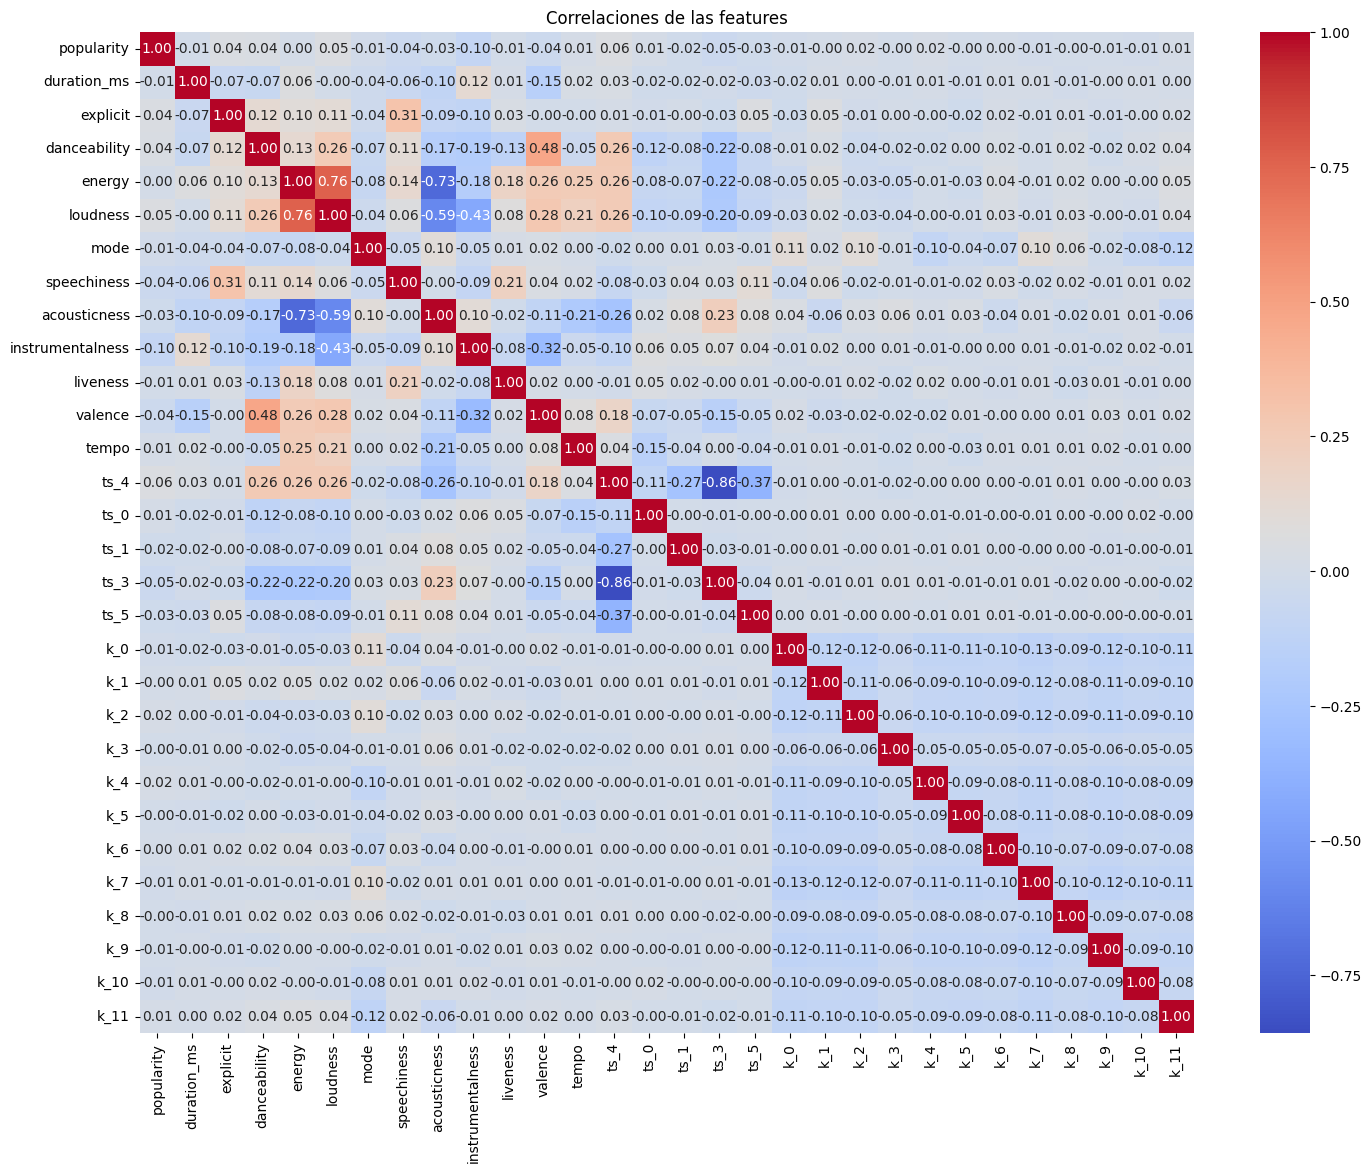

In [59]:
correlation_matrix = df.drop(columns=non_feature_columns).corr()

plt.figure(figsize=(17, 13))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlaciones de las features")
plt.show()

A partir de esta matriz de correlaciones entre las características de las canciones, se pueden extraer varias conclusiones:

En primer lugar, destaca la correlación positiva entre la energía de una canción y su nivel de volumen ('loudness'), lo cual resulta lógico, ya que las canciones con mayor energía suelen tener una producción más intensa y un sonido más potente.

Por otro lado, también es interesante la correlación negativa entre la energía y la 'acousticness'. Esto podría deberse a que las canciones más acústicas tienden a ser más suaves y orgánicas, mientras que aquellas con mayor energía suelen incorporar instrumentación eléctrica y una producción más intensa.

Otro aspecto relevante es la correlación positiva entre la 'danceability' y la valencia, lo que sugiere que las canciones con un índice de positividad más alto tienden a ser más bailables.

En la matriz también se observan correlaciones entre las 'time_signatures', todas ellas negativas, lo cual tiene sentido, ya que una canción no puede tener simultáneamente dos compases distintos. Destacan los compases 3/4 y 4/4, que parecen ser los más habituales. Además, el compás 3/4 muestra una mayor correlación con canciones de carácter acústico, mientras que el 4/4 está más asociado a temas con mayor bailabilidad, energía y positividad.

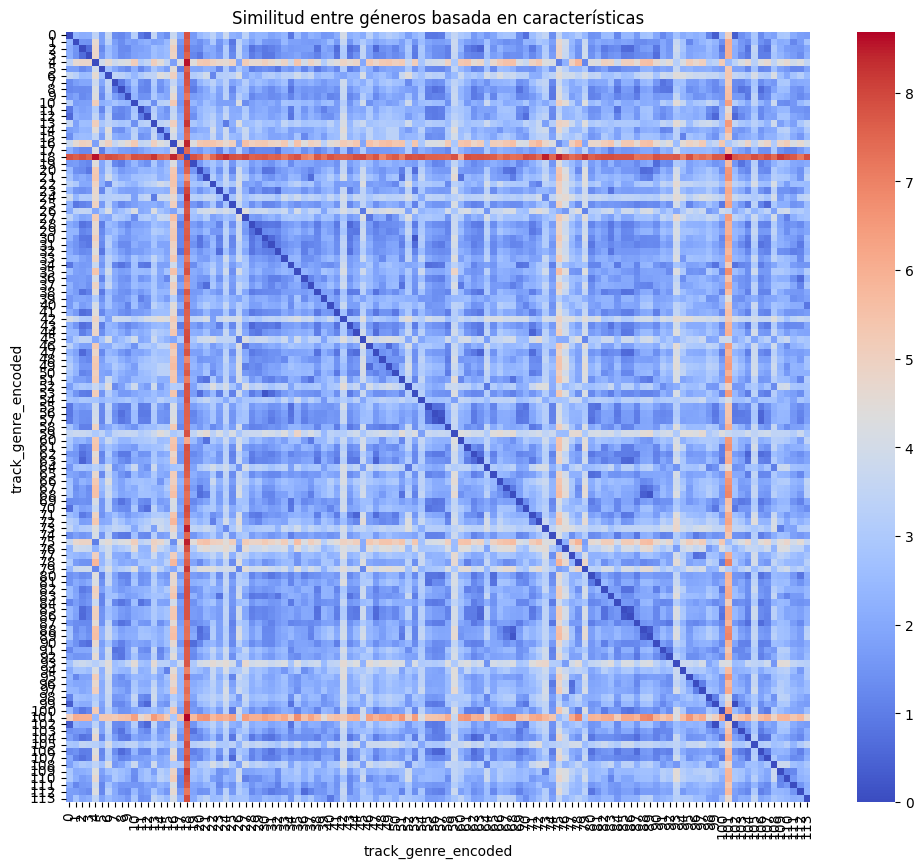

In [61]:
# Agrupar por género
genre_profiles = df.drop(columns=non_feature_columns)
genre_profiles['track_genre_encoded'] = df['track_genre_encoded']
genre_profiles = genre_profiles.groupby('track_genre_encoded').mean()

# Calcular una matriz de distancia entre géneros
# metric: ['euclidean', 'cosine', 'correlation']
distance_matrix = pdist(genre_profiles, metric='euclidean')
distance_df = pd.DataFrame(
    squareform(distance_matrix),
    index=genre_profiles.index,
    columns=genre_profiles.index
)

# Visualizar la matriz de distancias
plt.figure(figsize=(12, 10))
sns.heatmap(distance_df, cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.title('Similitud entre géneros basada en características')
plt.show()

In [72]:
# Crear una lista de pares de géneros con sus distancias
processed_pairs = set()
pairs = []
for genre1 in distance_df.columns:
    for genre2 in distance_df.columns:
        if genre1 != genre2:
            # Esto se puede hacer porque estamos considerando una funcion de distancia es simétrica            
            if (genre1, genre2) not in processed_pairs and (genre2, genre1) not in processed_pairs:
                pairs.append((int(genre1), int(genre2), distance_df.loc[genre1, genre2]))
                processed_pairs.add((genre1, genre2))
                

# Convertir la lista en un DataFrame
pairs_df = pd.DataFrame(pairs, columns=['genre_encoded_1', 'genre_encoded_2', 'distance'])
pairs_df['genre_1'] = LE.inverse_transform( pairs_df['genre_encoded_1'] )
pairs_df['genre_2'] = LE.inverse_transform( pairs_df['genre_encoded_2'] )
sorted_pairs = pairs_df.sort_values(by='distance').drop(columns=['genre_encoded_1', 'genre_encoded_2'])

print("Lista de pares de géneros musicales más similares en base a la similaridad calculada:")
pd.set_option('display.max_rows', None)  # Muestra todas las filas
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.width', None)  # Evita el corte de texto largo
print(sorted_pairs.head(20))

Lista de pares de géneros musicales más similares en base a la similaridad calculada:
          distance            genre_1            genre_2
6338  6.938894e-18  singer-songwriter         songwriter
6035  1.785720e-01               punk          punk-rock
2977  1.848602e-01                edm              house
5426  1.956044e-01             latino          reggaeton
4788  2.003219e-01              indie          indie-pop
6116  2.823100e-01             reggae          reggaeton
101   3.511608e-01           acoustic         songwriter
98    3.511608e-01           acoustic  singer-songwriter
5425  3.991746e-01             latino             reggae
4245  4.560971e-01          hard-rock             j-rock
285   4.804774e-01           alt-rock             j-rock
4893  4.828021e-01          indie-pop            swedish
5156  5.030723e-01              j-pop            spanish
4052  5.078226e-01             grunge              metal
4837  5.113523e-01              indie            swedish
51

El análisis de distancias entre géneros musicales muestra relaciones interesantes de similitud entre ellos. Se observa que el par más similar es `'singer-songwriter'` y `'songwriter'`, con una distancia prácticamente nula, lo cual es esperable dado que ambos términos suelen usarse indistintamente para describir artistas que componen e interpretan sus propias canciones. Otros pares con alta similitud incluyen `'punk'` y `'punk-rock'`, lo que indica que estos subgéneros comparten muchas características estilísticas y sonoras. Del mismo modo, `'EDM'` y `'house'` presentan una fuerte afinidad, lo que concuerda con la idea de que el house es una de las ramas más influyentes dentro de la música electrónica.

In [73]:
print("Lista de los géneros musicales más parecidos al conjunto de géneros metal:")
metal_similarities = sorted_pairs[ (sorted_pairs["genre_1"].isin(metal_genres)) | (sorted_pairs["genre_2"].isin(metal_genres)) ]
metal_similarities = metal_similarities.sort_values(by="distance")
print(metal_similarities.head(20))

Lista de los géneros musicales más parecidos al conjunto de géneros metal:
      distance      genre_1      genre_2
4052  0.507823       grunge        metal
4253  0.657983    hard-rock        metal
5551  0.858573        metal         punk
2912  0.884319      dubstep        metal
3970  0.887222       groove   industrial
3821  0.899234         goth  heavy-metal
4913  0.915000   industrial        metal
5552  0.919367        metal    punk-rock
5173  0.924720       j-rock        metal
293   0.944960     alt-rock        metal
3983  0.953210       groove        metal
4445  0.954050  heavy-metal        metal
4432  0.970990  heavy-metal   industrial
4305  0.977324     hardcore   industrial
5538  0.977543        metal    metalcore
2828  0.995523          dub        metal
3829  1.009756         goth   industrial
3842  1.013027         goth        metal
3623  1.022544       garage        metal
390   1.059263  alternative   industrial


Por otro lado, al buscar cuáles son los géneros más afines al conjunto de géneros que se ha definido como `'metal_genres'` para el desarrollo de este estudio, nos encontramos con relaciones interesantes. Los géneros más similares al metal incluyen `'grunge'` y `'hard-rock'`, lo cual tiene sentido, ya que ambos estilos comparten raíces en el `'hard-rock'` y una instrumentación agresiva. También se observa una notable proximidad con el `'punk'` y el `'punk-rock'`, reflejando la influencia del `'punk'` en la evolución del metal, especialmente en géneros como el `'thrash-metal'`.

Con todo ello, podemos sacar en claro que muchos géneros musicales comparten características, lo que a veces dificulta la asignación de un único género a una canción. Por ello, se ha decidido explorar y visualizar las distribuciones de las variables, aplicar técnicas de clustering para identificar grupos de géneros afines y estudiar cómo se distribuyen las variables dentro de estos grupos.

Se espera que, al analizar la normalidad de las variables en el conjunto completo de datos, las distribuciones se desvíen significativamente de una distribución normal. Sin embargo, al realizar este análisis dentro de los grupos de géneros musicales obtenidos a través del clustering, es probable que las variables tiendan más a una distribución normal, reflejando una mayor homogeneidad dentro de cada grupo.

11


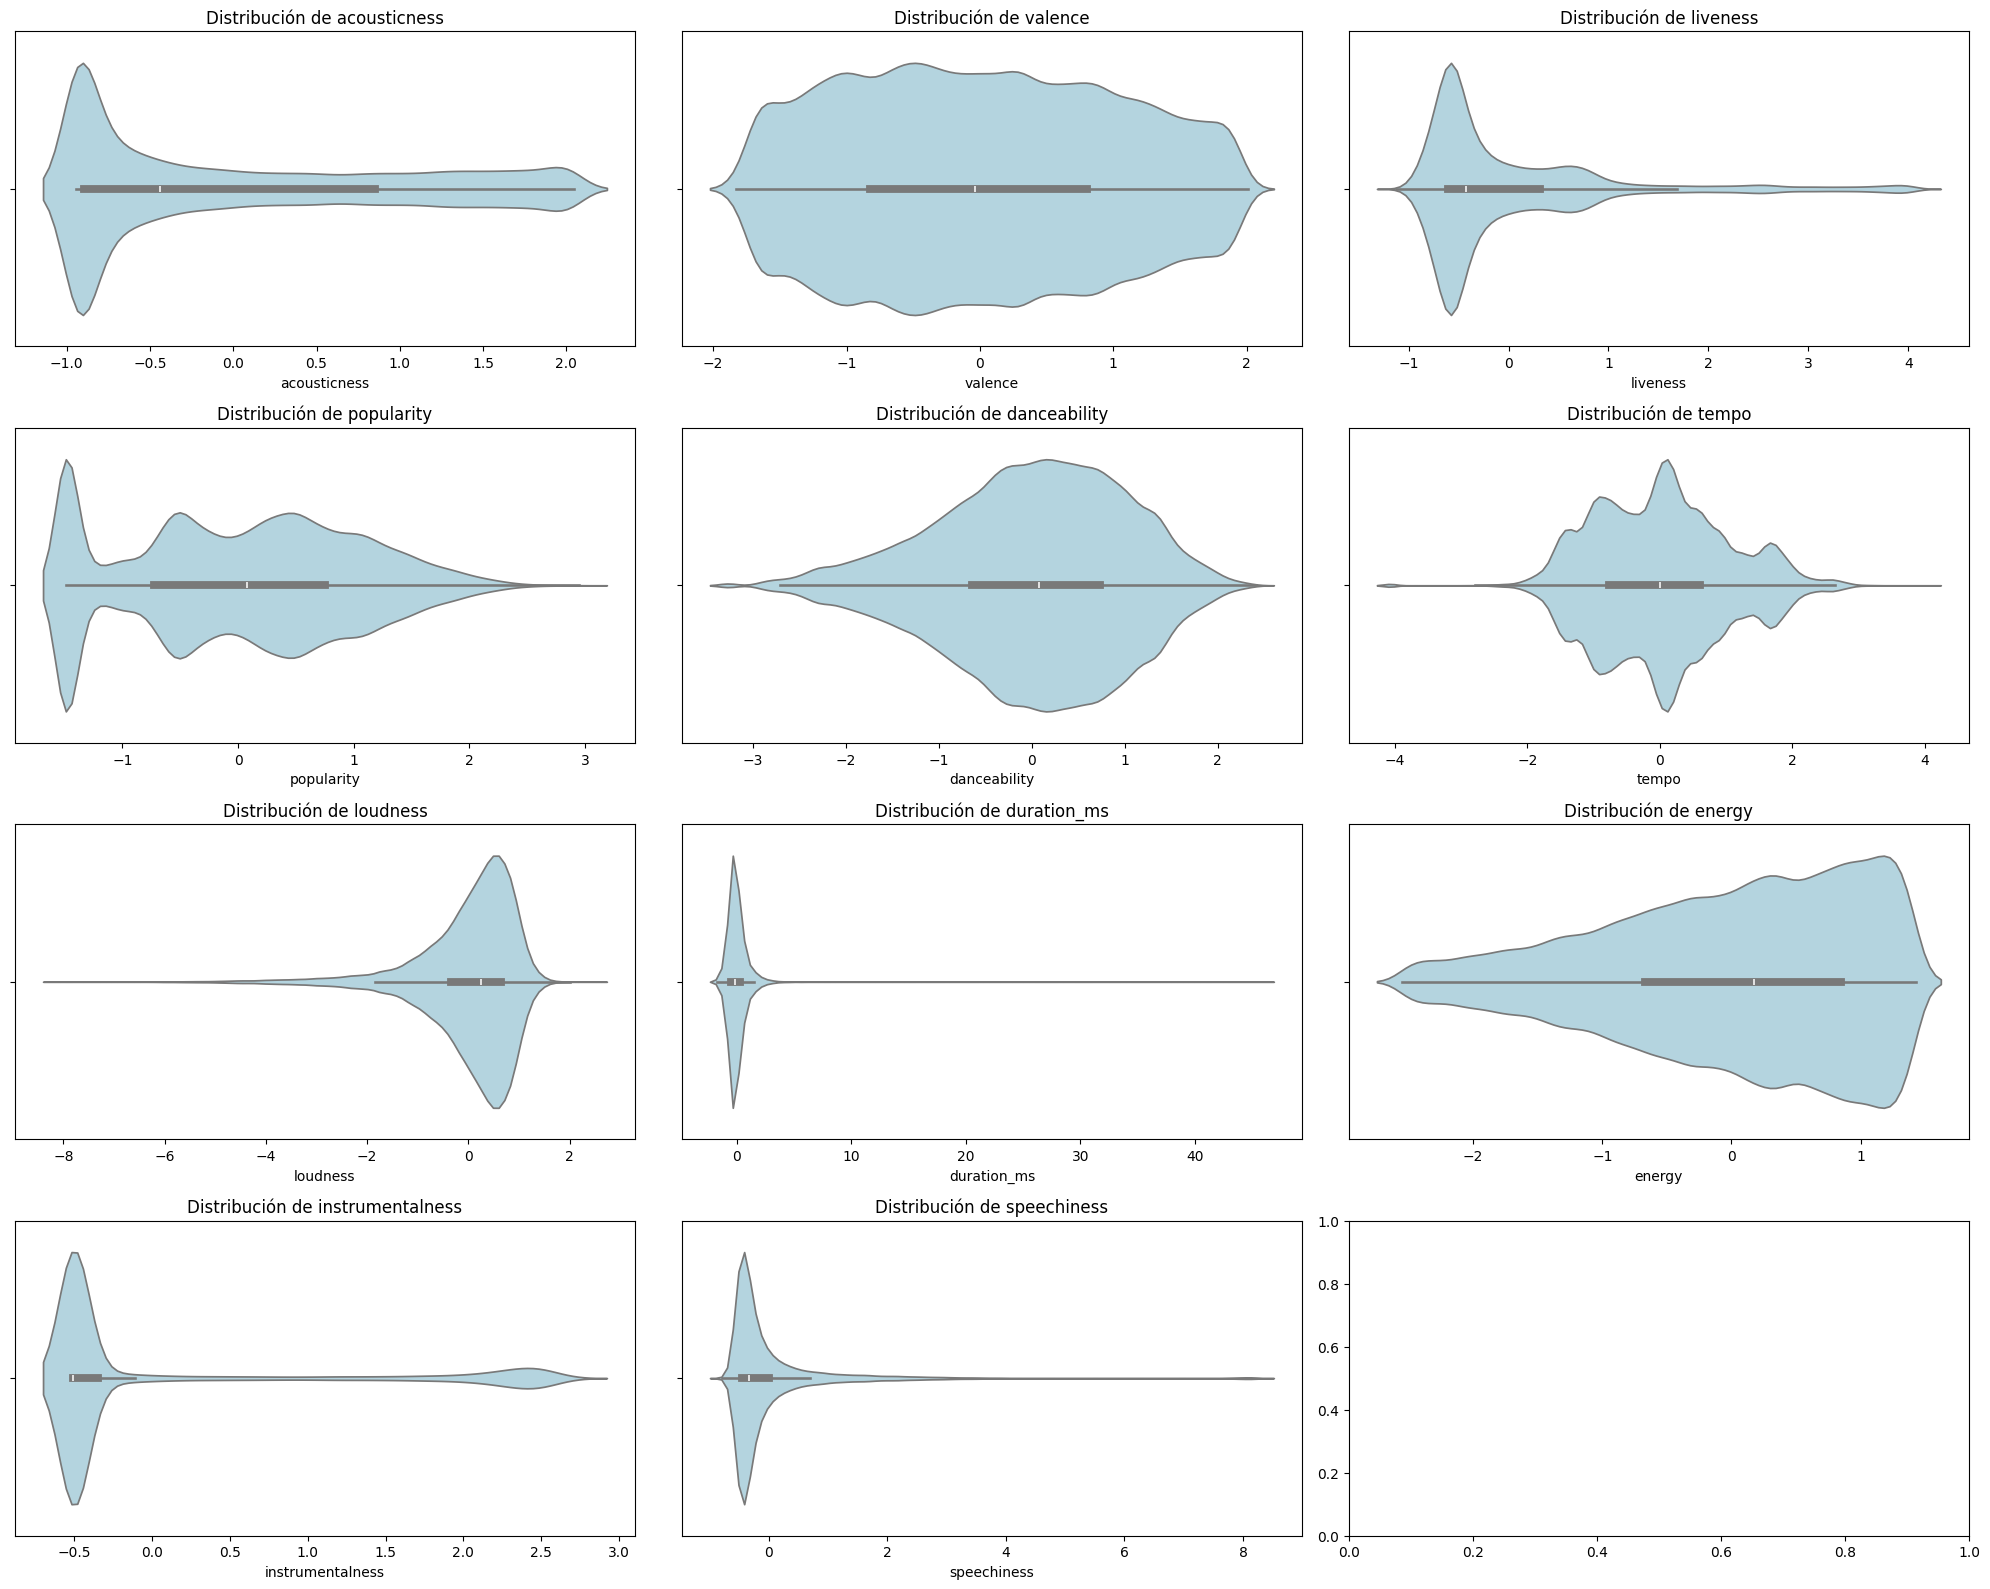

In [7]:
from scipy.stats import skew, kurtosis, shapiro

selected_columns = ['acousticness', 'valence', 'liveness', 'popularity', 'danceability', 
                    'tempo', 'loudness', 'duration_ms', 'energy', 'instrumentalness', 'speechiness' ]
# Non selected columns: track_genre_encoded, mode, explicit, time_signature
print(len(selected_columns))
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()


# Violin plot para cada variable numérica
stat_data = {}
for i, column in enumerate(selected_columns):
    sns.violinplot(x=df[column], color='lightblue', ax=axes[i])
    axes[i].set_title(f'Distribución de {column}')
    axes[i].set_xlabel(column)

    # Cálculo de asimetría y curtosis
    mean = df[column].mean()
    std_dev = df[column].std()
    column_skewness = skew(df[column].dropna())
    column_kurtosis = kurtosis(df[column].dropna())
    stat, p_value = shapiro(df[column].dropna())
    
    stat_data[column] = {
        "mean": mean,
        "std_dev": std_dev,
        "skewness": column_skewness,
        "kurtosis": column_kurtosis,
        "shapiro":{"stat": stat, "p_value": p_value}
    }

plt.tight_layout()
plt.show()

In [18]:
for sd in stat_data.keys():
    if stat_data[sd]['shapiro']['p_value'] > 1e-10:
        print(stat_data[sd])

In [19]:
stat_data['duration_ms']

{'mean': np.float64(2.3934071099287587e-17),
 'std_dev': np.float64(1.0000043859937675),
 'skewness': np.float64(11.195034174569578),
 'kurtosis': np.float64(354.936795114302),
 'shapiro': {'stat': np.float64(0.6586784875945821),
  'p_value': np.float64(7.217900620336316e-152)}}

En el análisis del conjunto de datos completo, ninguna de las variables parece seguir una distribución normal, lo cual es evidente de forma visual. Además, al aplicar el test de _Shapiro-Wilk_ para evaluar la normalidad, ninguna variable ha presentado un p-valor superior a $1 \times 10^{-10}$. Esto hace que sea estadísticamente significativo concluir que ninguna de las variables se aproxima a una distribución normal. Este resultado sugiere que, al considerar todos los géneros musicales en conjunto, se están mezclando características de diferentes tipos de géneros, lo que contribuye a la falta de normalidad en las distribuciones observadas.

Por esta razón, se va a llevar a cabo un proceso de agrupamiento de los géneros musicales para identificar cuáles comparten características similares. El objetivo es analizar si, al agrupar los géneros musicales las distribuciones de las variables dentro de esos grupos se acercan más a una distribución normal.

Agrupaciones de géneros musicales calculadas:
['dance', 'dancehall', 'emo', 'funk', 'hardcore', 'hip-hop', 'j-dance', 'kids', 'latin', 'latino', 'reggae', 'reggaeton']
['alt-rock', 'alternative', 'country', 'disco', 'forro', 'garage', 'goth', 'hard-rock', 'j-idol', 'j-rock', 'malay', 'pagode', 'party', 'power-pop', 'punk', 'punk-rock', 'rock', 'salsa', 'samba', 'sertanejo', 'ska', 'soul', 'synth-pop']
['breakbeat', 'death-metal', 'drum-and-bass', 'dubstep', 'grunge', 'happy', 'hardstyle', 'heavy-metal', 'industrial', 'metal', 'metalcore', 'trance']
['opera', 'romance']
['ambient', 'classical', 'disney', 'guitar', 'new-age', 'piano']
['acoustic', 'british', 'cantopop', 'german', 'gospel', 'mandopop', 'psych-rock', 'show-tunes', 'singer-songwriter', 'songwriter', 'world-music']
['afrobeat', 'anime', 'blues', 'brazil', 'club', 'deep-house', 'dub', 'edm', 'electro', 'electronic', 'folk', 'groove', 'house', 'indian', 'indie', 'indie-pop', 'j-pop', 'k-pop', 'mpb', 'pop', 'pop-film', 'progres

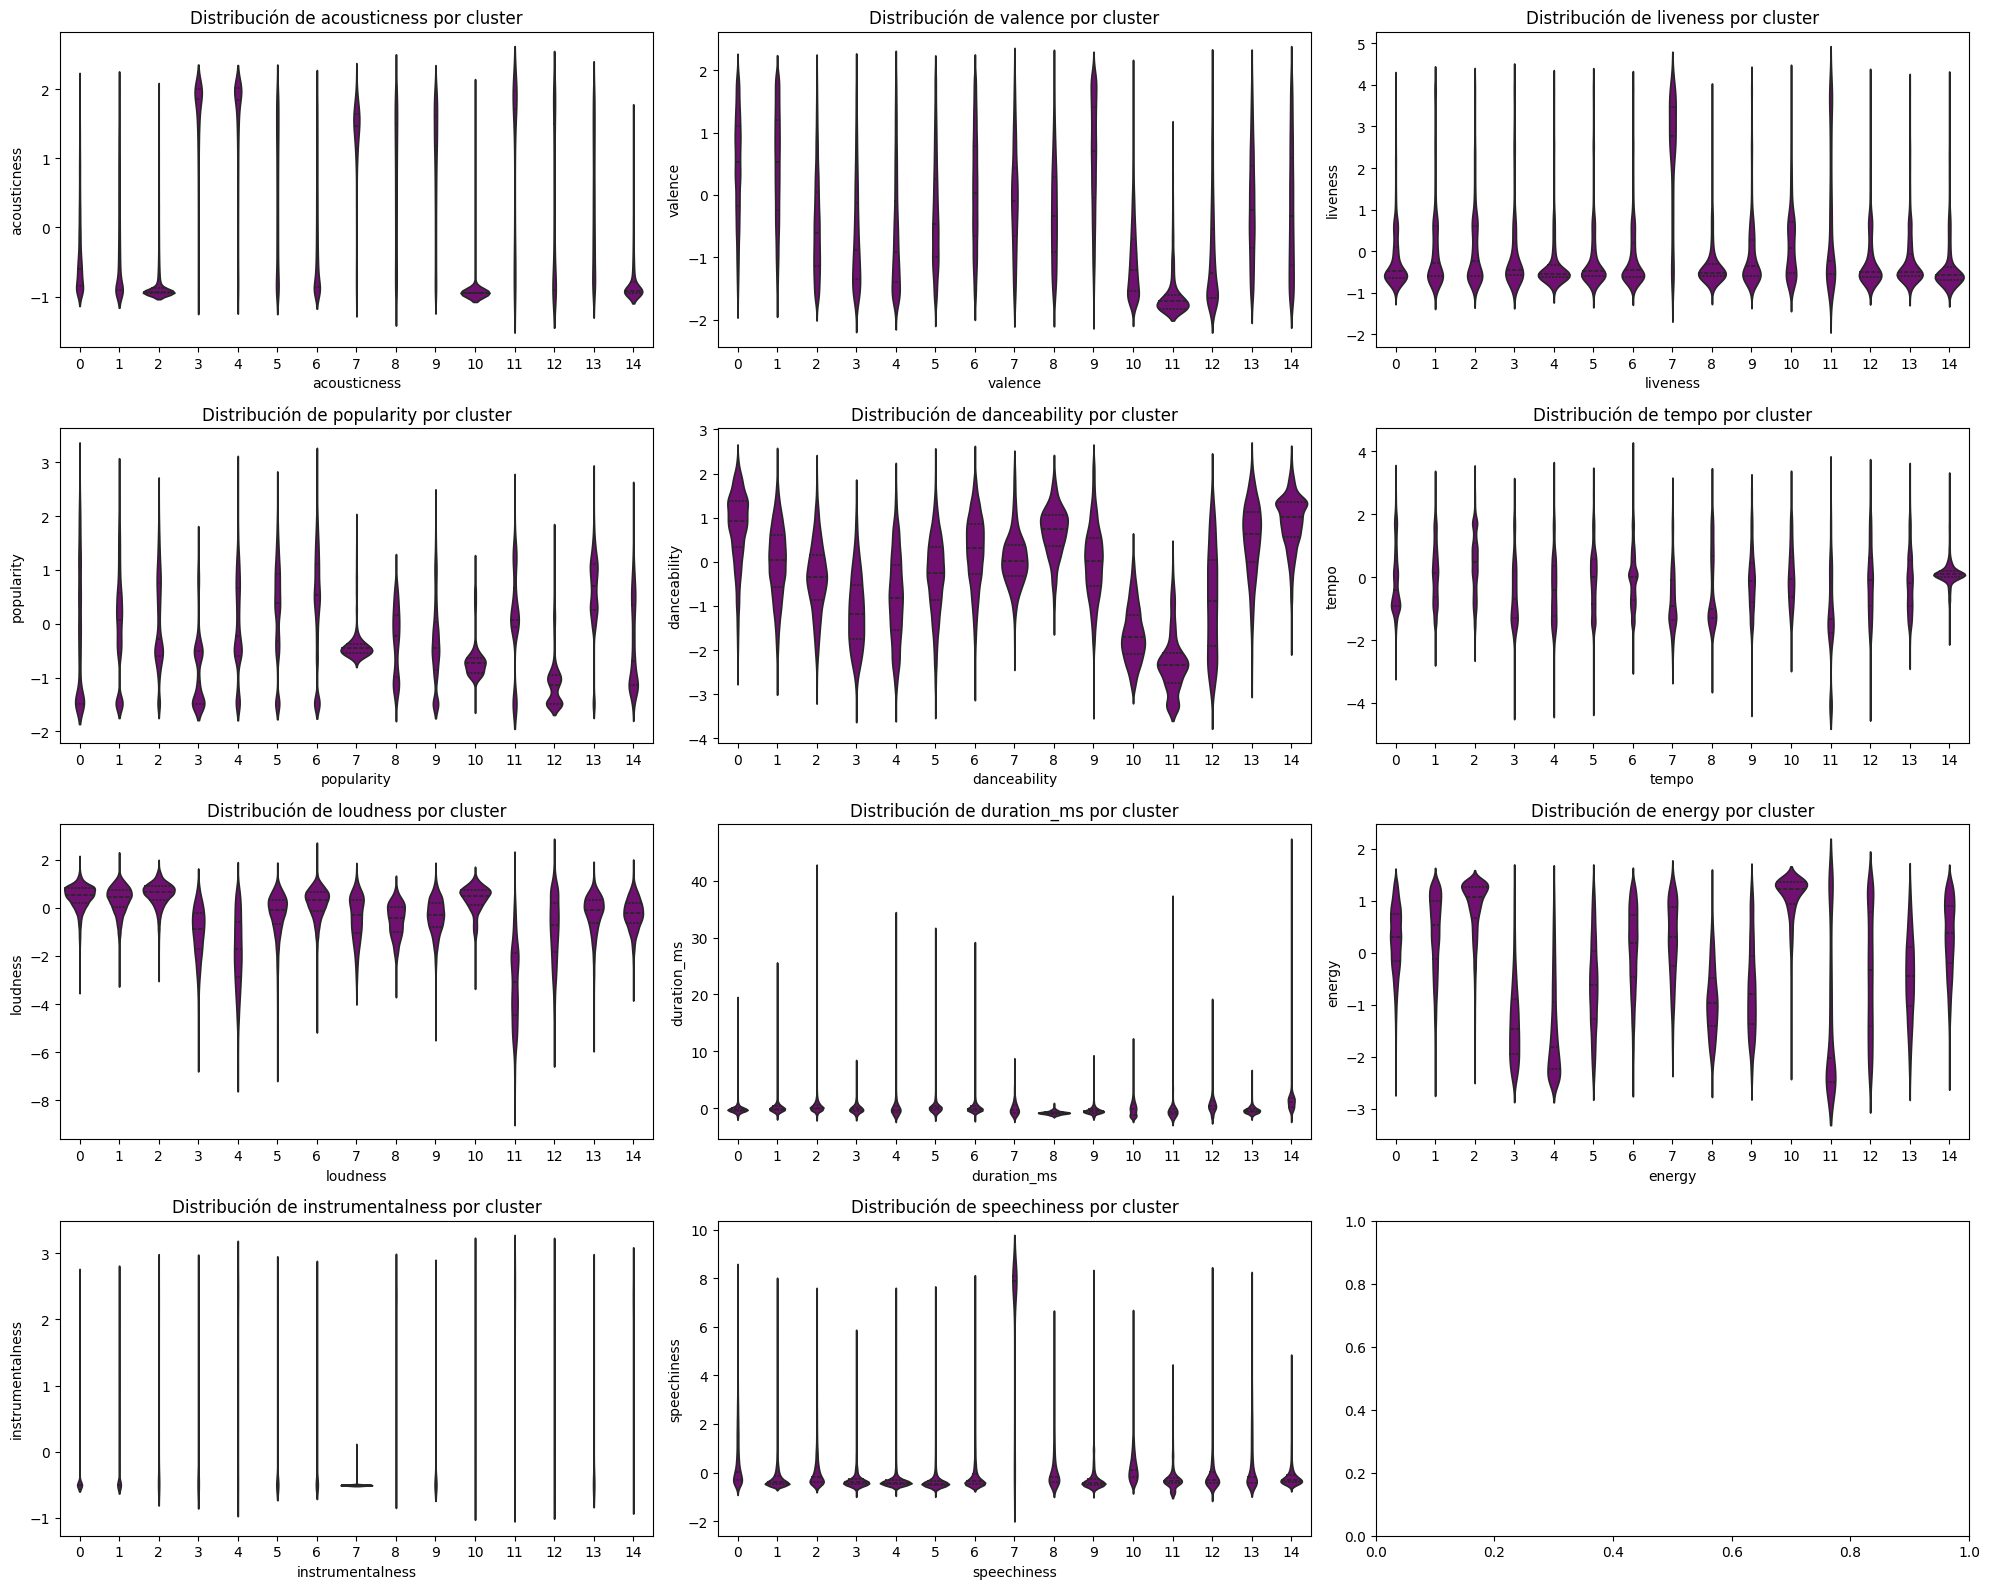

In [80]:
n_clusters = 15 # partiendo de 114
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
cluster_labels = clustering.fit_predict(squareform(distance_matrix))

# Crear un DataFrame para ver cómo se agrupan los géneros
clustered_genres = pd.DataFrame({
    'track_genre_encoded': distance_df.columns,
    'cluster': cluster_labels
})

# Asignar los nuevos clusters a los géneros musicales
clustered_genres['track_genre'] = LE.inverse_transform(clustered_genres['track_genre_encoded'].astype(int))
print("Agrupaciones de géneros musicales calculadas:")
CE = clustered_genres.groupby('cluster')['track_genre'].apply(list) # Cluster Encoder
for c in CE:
    print(c)


# Hacer un violin plot por cada variable y cada cluster agrupando los datos
df['cluster'] = df['track_genre_encoded'].map(clustered_genres.set_index('track_genre_encoded')['cluster'])
non_feature_columns.append("cluster")

selected_columns = ['acousticness', 'valence', 'liveness', 'popularity', 'danceability', 
                    'tempo', 'loudness', 'duration_ms', 'energy', 'instrumentalness', 'speechiness']
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()
for i, column in enumerate(selected_columns):
    sns.violinplot(x='cluster', y=column, data=df, color='purple', inner="quart", ax=axes[i])
    axes[i].set_title(f'Distribución de {column} por cluster')
    axes[i].set_xlabel(column)
plt.tight_layout()
plt.show()


Las agrupaciones de géneros musicales muestran cómo se pueden clasificar diferentes estilos musicales en grupos con características similares. Por ejemplo, en el primer grupo se encuentran géneros orientados al baile como `'dance'`, `'hip-hop'`, `'reggaeton'` y `'latino'`. En el segundo grupo, se agrupan géneros como `'rock'`, `'punk'`, `'ska'` y `'disco'`, que comparten influencias de música alternativa y subgéneros del rock. Otros grupos incluyen estilos más pesados, como el `'metal'` y `'grunge'`, así como géneros más suaves y tranquilos como `'ambient'`, `'classical'` y `'new-age'`. También hay agrupaciones que combinan géneros acústicos y alternativos, como `'acoustic'` y `'singer-songwriter'`, y géneros más electrónicos como `'edm'`, `'electro'` y `'house'`.


11


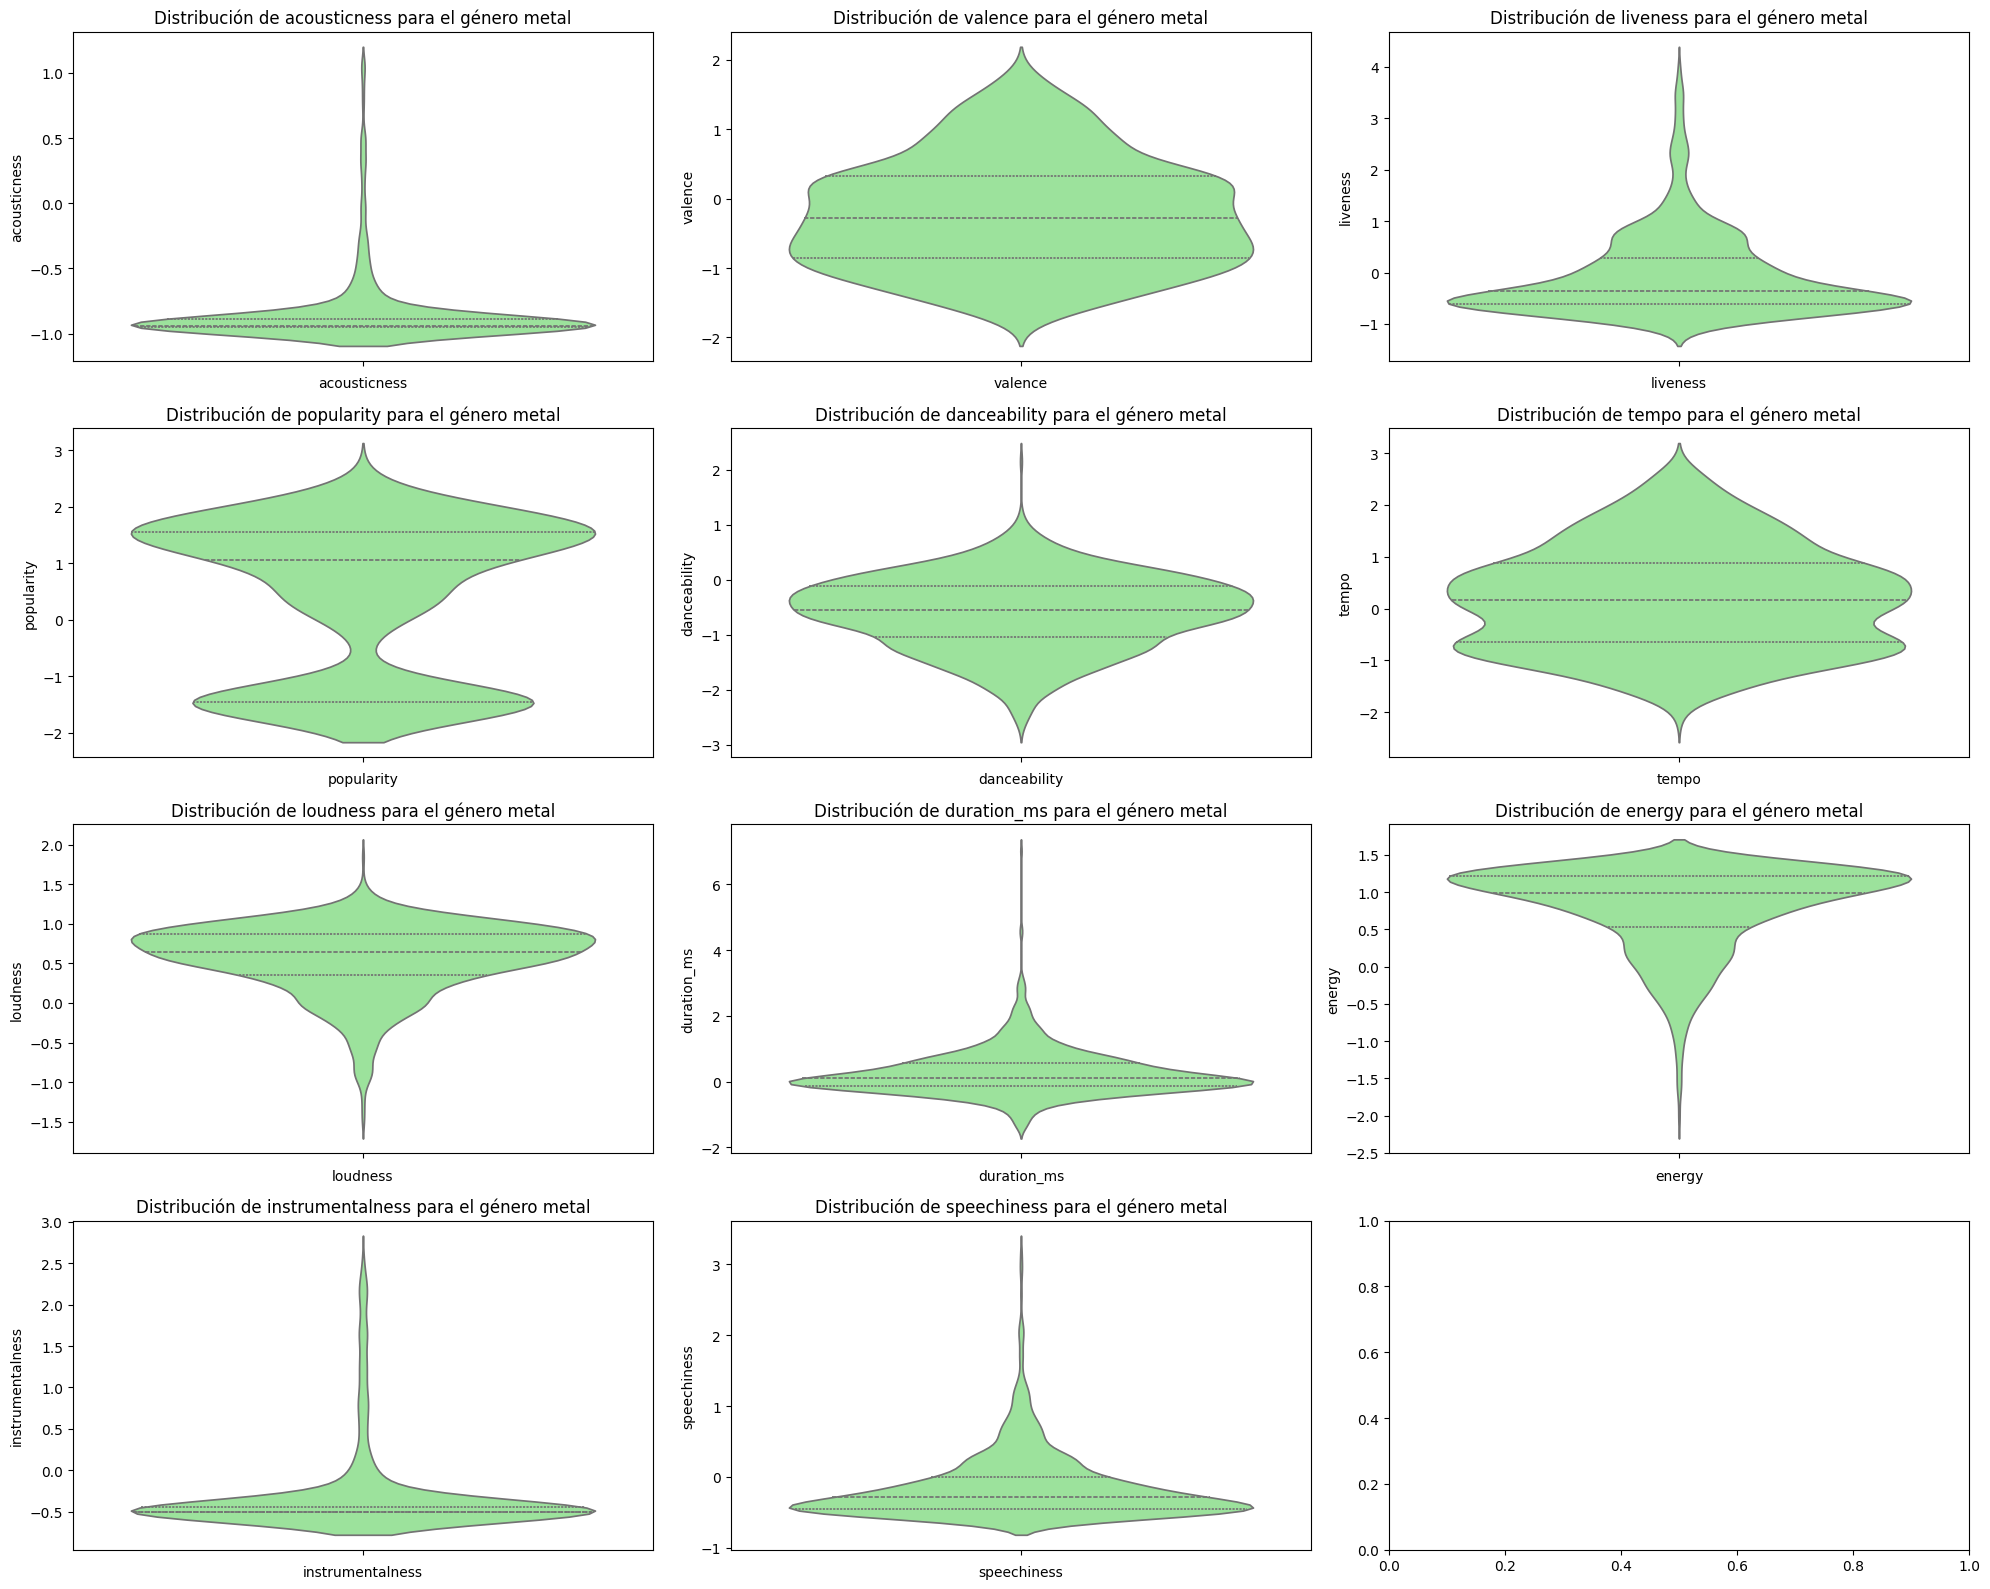

In [28]:
selected_columns = ['acousticness', 'valence', 'liveness', 'popularity', 'danceability', 
                    'tempo', 'loudness', 'duration_ms', 'energy', 'instrumentalness', 'speechiness' ]
# Non selected columns: track_genre_encoded, mode, explicit, time_signature
print(len(selected_columns))
selected_genre = list(LE.classes_).index('metal') # np.random.randint(low=0, high=len(LE.classes_))
filtered_df = df[df['track_genre_encoded'] == selected_genre]

# Crear un gráfico de violín para cada columna seleccionada
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()
for i, column in enumerate(selected_columns):
    sns.violinplot(y=column, data=filtered_df, inner="quart", color="lightgreen", ax=axes[i])
    axes[i].set_title(f'Distribución de {column} para el género {LE.classes_[selected_genre]}')
    axes[i].set_xlabel(column)

plt.tight_layout()
plt.show()

Con todo ello, parece que las agrupaciones hacen que las distribuciones de las variables se acerquen más a una distribución normal, al menos de manera visual. Sin embargo, no se puede olvidar el hecho de que las canciones aunque pertenezcan a un género en específico, como es el caso del `'metal'`, pueden contener rasgos de otros géneros musicales. No todo es blanco o negro. Es por ello que también es interesante detectar estos outliers para ver cómo se comportan.

Además, hay que recordar que el objetivo final es el de crear un clasificador binario que discierna entre canciones del conjunto de géneros metal y las demás, componiendo un dataset final muy desbalandeado. 

In [6]:
# Create the binary target variable
df['is_metal'] = df['track_genre'].apply(lambda x: 1 if x in metal_genres else 0)
non_feature_columns.append("is_metal")
# df.head()

X = df.drop(columns=non_feature_columns)  # Features
y = df['is_metal']  # Target

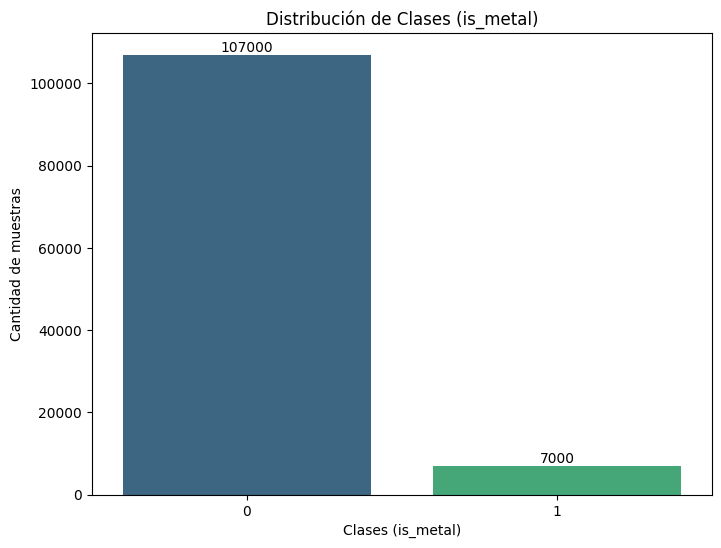

In [12]:
def plot_class_counts(y):
    class_counts = y.value_counts()

    # Crear el gráfico de barras
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
    plt.text(0, class_counts[0], str(class_counts[0]), ha='center', va='bottom')
    plt.text(1, class_counts[1], str(class_counts[1]), ha='center', va='bottom')

    # Añadir etiquetas y título
    plt.xlabel('Clases (is_metal)')
    plt.ylabel('Cantidad de muestras')
    plt.title('Distribución de Clases (is_metal)')
    plt.show()
plot_class_counts(y)

## 4 - Visualizar los datos

A continuación, se van a emplear técnicas de reducción de dimensionalidad, como PCA (Análisis de Componentes Principales) y t-SNE (t-Distributed Stochastic Neighbor Embedding), para proyectar las características del conjunto de datos en dos dimensiones. El objetivo de utilizar tanto PCA como t-SNE es obtener una representación gráfica para detectar cómo se distribuyen las clases y si existen agrupamientos de géneros musicales en el espacio reducido.

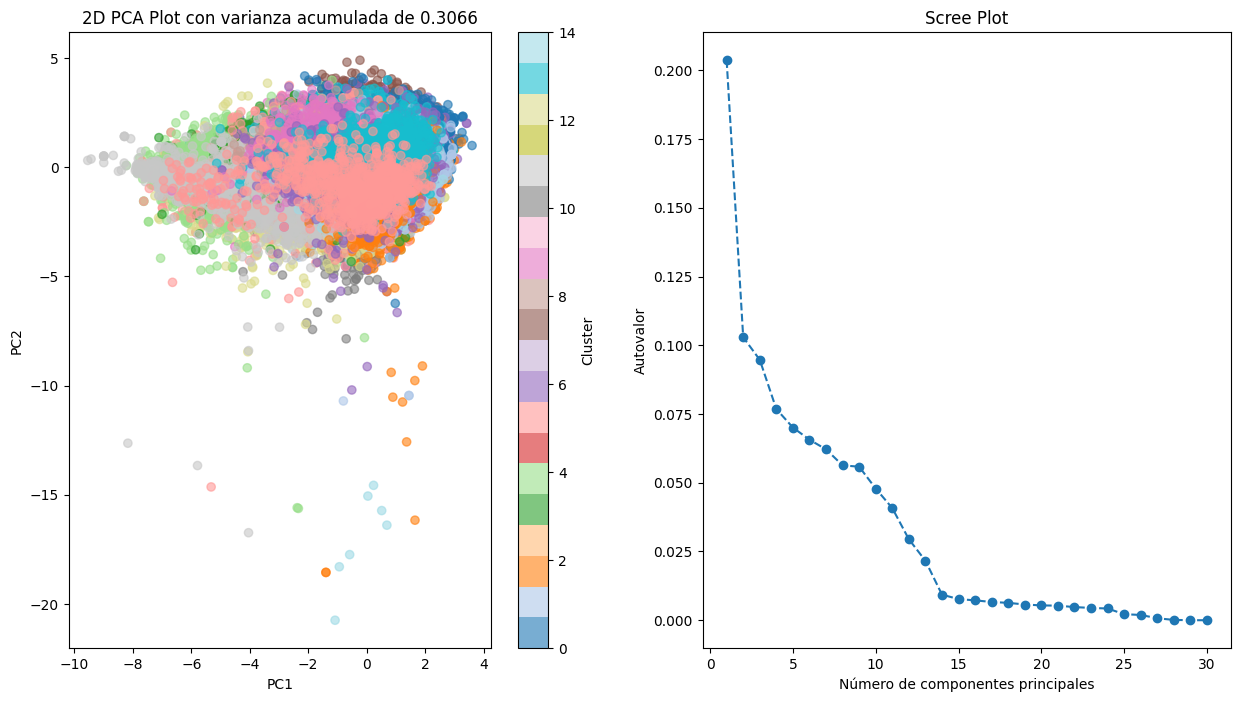

In [153]:
# Aplicar PCA
pca = PCA()
pca_result = pca.fit_transform(X)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
# print("PCA Varianza Acumulada:\n", cumulative_explained_variance)

# Dataframe con los datos del PCA para los plots
pca_df = pd.DataFrame(data=pca_result[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['cluster'] = df['cluster'].values

fig, axes = plt.subplots(1, 2, figsize=(15, 8))
# 2D Features con PCA
scatter = axes[0].scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['cluster'], cmap='tab20', alpha=0.6)
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_title(f"2D PCA Plot con varianza acumulada de {cumulative_explained_variance[1]:.4f}")
fig.colorbar(scatter, ax=axes[0], label='Cluster')

# Mostrar el scree plot
axes[1].plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
axes[1].set_xlabel('Número de componentes principales')
axes[1].set_ylabel('Autovalor')
axes[1].set_title('Scree Plot')

plt.show()

El gráfico de visualización utilizando las dos primeras componentes principales del PCA no resulta representativo en este caso. La varianza acumulada es bastante baja y tampoco mejora demasiado al incorporar la tercera componente. Además, como ya se había observado previamente, las clases están muy aglomeradas, lo que refleja que los géneros musicales a menudo comparten características y se mezclan entre sí. 

En resumen, esta técnica de visualización no ofrece nueva información útil para el análisis de los géneros musicales.

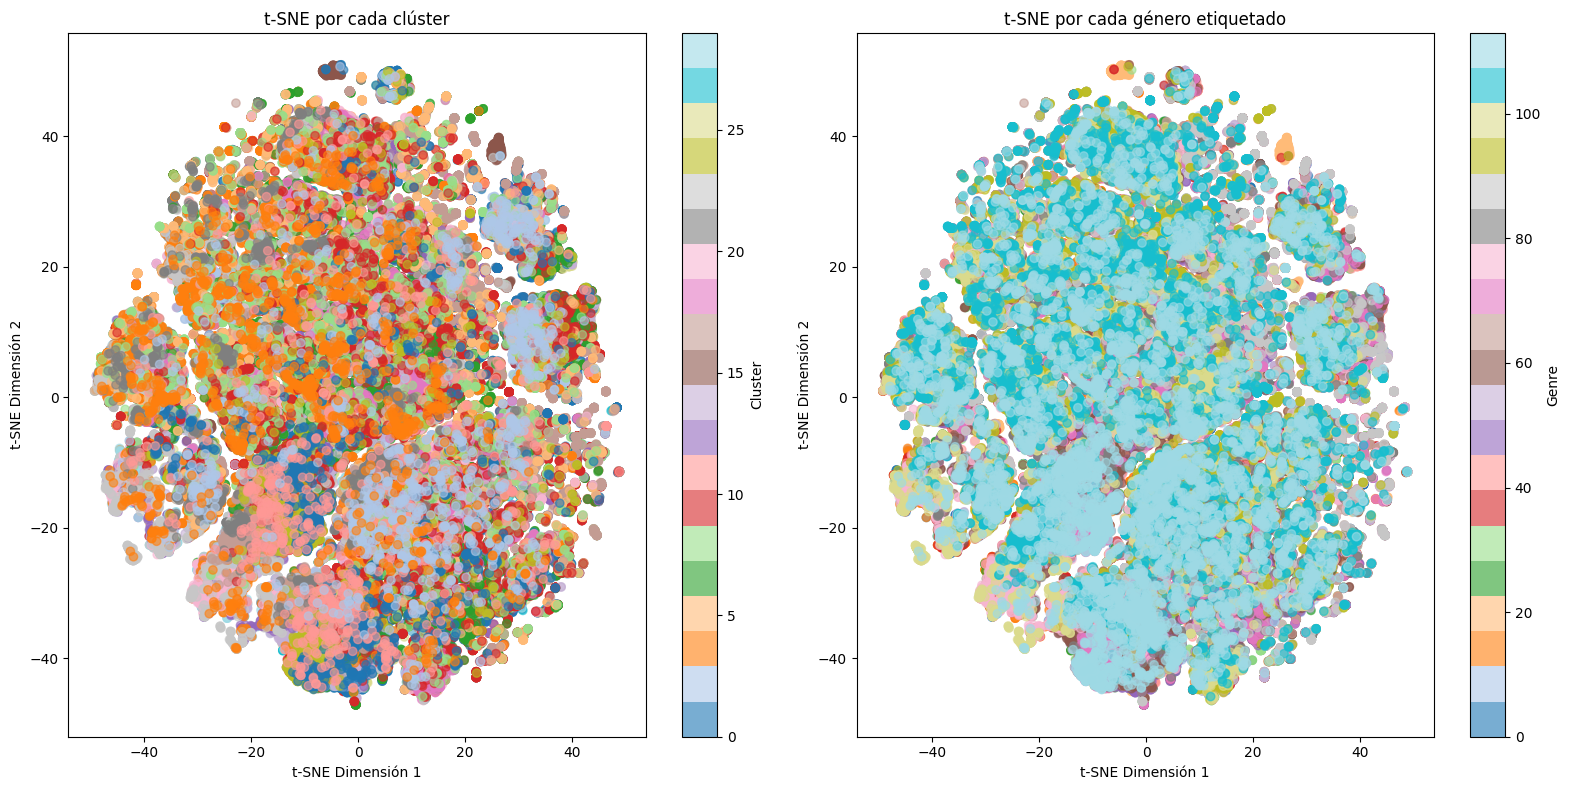

In [31]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42, learning_rate=200, max_iter=1000)
tsne_result = tsne.fit_transform(X)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['track_genre_encoded'] = df['track_genre_encoded'].values
tsne_df['cluster'] = df['cluster'].values

# t_SNE Clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
scatter1 = axes[0].scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['cluster'], cmap='tab20', alpha=0.6)
axes[0].set_title("t-SNE por cada clúster")
axes[0].set_xlabel("t-SNE Dimensión 1")
axes[0].set_ylabel("t-SNE Dimensión 2")
fig.colorbar(scatter1, ax=axes[0], label='Cluster')

# t_SNE Genres
scatter2 = axes[1].scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['track_genre_encoded'], cmap='tab20', alpha=0.6)
axes[1].set_title("t-SNE por cada género etiquetado")
axes[1].set_xlabel("t-SNE Dimensión 1")
axes[1].set_ylabel("t-SNE Dimensión 2")
fig.colorbar(scatter2, ax=axes[1], label='Genre')

plt.tight_layout()
plt.show()

Con la visualización empleando t-SNE ocurre algo similar que con el PCA. A pesar de que parecen distinguirse algunas estructuras de clúster, éstas no se relacionan con ningún género musical en particular. Los géneros musicales aparecen muy dispersos y superpuestos unos con otros. Estas superposiciones y poca diferenciación se mantiene también al clasificar las instancias en función de si pertenecen al conjunto metal o no:

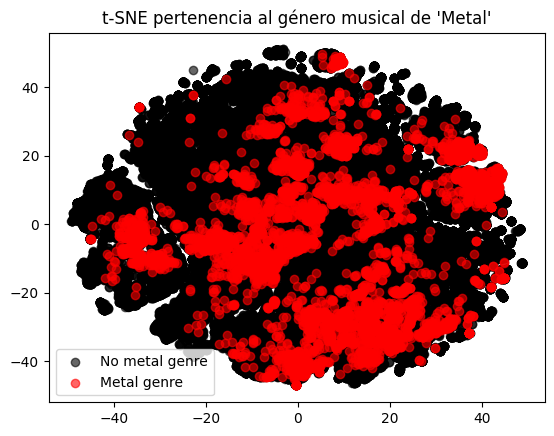

In [32]:
tsne_df['is_metal'] = np.where( df['is_metal'], True, False)
plt.scatter(tsne_df[~tsne_df['is_metal']]['TSNE1'], tsne_df[~tsne_df['is_metal']]['TSNE2'], alpha=0.6, label='No metal genre', c='black')
plt.scatter(tsne_df[tsne_df['is_metal']]['TSNE1'], tsne_df[tsne_df['is_metal']]['TSNE2'], alpha=0.6, label='Metal genre', c='red')
plt.title("t-SNE pertenencia al género musical de 'Metal'")
plt.legend()
plt.show()

## 5 - Detección de outliers

Como se ha mencionado, la asignación de un género musical a una canción no siempre es clara. Además, en este caso de estudio, estamos considerando el género musical "metal" para realizar el estudio, género que a su vez es una agrupación de otros subgéneros, y tambiñen se ha comprobado como las variables descriptivas de las canciones no siguen una distribución normal, son asimétricas y parecen incluir valores atípicos (outliers). Esto plantea un desafío a la hora de analizar los datos y entrenar un clasificador, ya que es importante determinar si estos outliers deben ser considerados o excluidos de antemano. 

Una primera aproximación, aunque simple, consiste en asumir que las features deberían seguir una distribución normal y utilizar el z-score para identificar outliers. Sin embargo, dado que los datos no se ajustan a una distribución normal, también se propone emplear el Local Outlier Factor (LOF), que permite detectar outliers locales basándose en la densidad de los datos.

### Z-Score

In [12]:
def plot_num_outliers_by_thresholds(z_scores, thresholds: list, title=""):
    num_outliers = []
    for thr in thresholds:
        outliers = (z_scores > thr).any(axis=1)
        num_outliers.append(outliers.sum())
    plt.plot(thresholds, num_outliers)
    plt.title(title)
    plt.legend()
    plt.show()

def plot_z_outliers_by_threshols(z_scores, tsne_df, thresholds: list):
    num_plots = len(thresholds)
    cols = math.ceil(math.sqrt(num_plots))
    rows = math.ceil(num_plots / cols)

    plt.tight_layout()
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), sharex=True, sharey=True)
    axes = np.array(axes).reshape(rows, cols)
    for thr, i in zip(thresholds, range(num_plots)):
        r, c = divmod(i, cols)
        outliers = (z_scores > thr).any(axis=1)
        tsne_df['is_outlier_zscore'] = outliers

        # Show graph
        axes[r,c].scatter(tsne_df[~tsne_df['is_outlier_zscore']]['TSNE1'], tsne_df[~tsne_df['is_outlier_zscore']]['TSNE2'], alpha=0.6, label='Normal', c='black')
        axes[r,c].scatter(tsne_df[tsne_df['is_outlier_zscore']]['TSNE1'], tsne_df[tsne_df['is_outlier_zscore']]['TSNE2'], alpha=0.6, label='Outlier', c='red')
        axes[r,c].set_title(f"Outliers según Z-Score > {thr} en t-SNE")
        axes[r,c].set_xlabel("PC1")
        axes[r,c].set_ylabel("PC2")
    
    plt.legend()
    plt.show()

In [158]:
X.head()

popularity  duration_ms  explicit  danceability    energy  loudness  \
0    1.782627     0.024575 -0.305767      0.629244 -0.717148  0.300828   
1    0.975633    -0.730859 -0.305767     -0.845908 -1.889980 -1.784744   
2    1.065299    -0.160332 -0.305767     -0.742186 -1.122669 -0.293288   
3    1.692961    -0.243214 -0.305767     -1.733304 -2.312994 -2.039252   
4    2.186125    -0.271919 -0.305767      0.295030 -0.788711 -0.282750   

       mode  speechiness  acousticness  instrumentalness  liveness   valence  \
0 -1.326281     0.551848     -0.850202         -0.504109  0.758743  0.929306   
1  0.753988    -0.078993      1.831732         -0.504094 -0.591211 -0.798690   
2  0.753988    -0.273826     -0.315499         -0.504112 -0.507167 -1.365688   
3  0.753988    -0.457309      1.774593         -0.503883 -0.428376 -1.276974   
4  0.753988    -0.303145      0.463399         -0.504112 -0.686285 -1.184403   

      tempo      ts_4   ts_0   ts_1   ts_3   ts_5    k_0    k_1    k_2    k_3  \
0 -1.141863  0.345500  False  False  False  False  False   True  False  False   
1 -1.489717  0.345500  False  False  False  False  False   True  False  False   
2 -1.528312  0.345500  False  False  False  False   True  False  False  False   
3  1.987859 -2.894359  False  False   True  False   True  False  False  False   
4 -0.073348  0.345500  False  False  False  False  False  False   True  False   

     k_4    k_5    k_6    k_7    k_8    k_9   k_10   k_11  
0  False  False  False  False  False  False  False  False  
1  False  False  False  False  False  False  False  False  
2  False  False  False  False  False  False  False  False  
3  False  False  False  False  False  False  False  False  
4  False  False  False  False  False  False  False  False

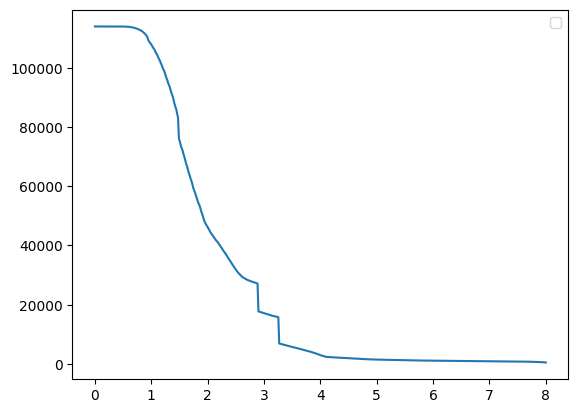

In [13]:
# Calcular Z-Score para todas las features
z_scores = np.abs(zscore(X.drop(columns=non_scaling_features)))

# Mostrar el número de outliers variando el threshold
plot_num_outliers_by_thresholds(z_scores, np.linspace(0, 8, num=500))
# plot_z_outliers_by_threshols(z_scores, tsne_df, [2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6])

Se va considerar un threshold de $3.5$ para el outlierness de z_score:
- ¿Cuál es la canción con mayor z_score? 
- ¿Y la que tiene menor valor?

In [160]:
threshold = 3.5  # Umbral para considerar un outlier
outliers = (z_scores > threshold).any(axis=1)

df['is_outlier_zscore'] = outliers
#df['z_scores'] = z_scores
non_feature_columns.append("z_scores")  
non_feature_columns.append("is_outlier_zvalue")
print(f"Total de outliers detectados: {df['is_outlier_zscore'].sum()}")

Total de outliers detectados: 5733


In [27]:
outlier_magnitudes = z_scores.sum(axis=1)  

max_outlier_idx = np.argmax(outlier_magnitudes)  # Índice con el mayor Z-Score acumulado
min_outlier_idx = np.argmin(outlier_magnitudes)  # Índice con el menor Z-Score acumulado

max_outlier_instance = df.iloc[max_outlier_idx]
min_outlier_instance = df.iloc[min_outlier_idx]

# Mostrar resultados
print("Instancia con el mayor Z-Score acumulado (outlier más extremo):")
print(max_outlier_instance)
print("\nInstancia con el menor Z-Score acumulado (outlier menos extremo):")
print(min_outlier_instance)

Instancia con el mayor Z-Score acumulado (outlier más extremo):
popularity                                     0.123805
duration_ms                                   31.426575
explicit                                      -0.305767
danceability                                   -3.26608
energy                                        -2.547911
key                                            1.598569
loudness                                      -5.342684
mode                                           0.753988
speechiness                                    -0.80063
acousticness                                   1.900901
instrumentalness                               0.736385
liveness                                      -0.533431
valence                                       -1.828544
tempo                                         -4.074574
time_signature                                -9.024189
Unnamed: 0                                       101517
track_id                         5m00VnX

La pista de audio que presenta el mayor Z-score acumulado de todo el dataset es _Electric Fan (Sound Masking Fan)_ de Electric Dreams con el género asignado de _sleep_. Es interesante que una pista de audio del sonido de un ventilador eléctrico sea el outlier más significativo atendiendo únicamente al Z-Score, pero en cierta manera se podría interpretar que al ser un sonido muy monótono y cercano al ruido blanco se diferencia bastante del resto de canciones.

En contraposición, la canción de salsa _Celo_ de Willie Colón es aquella que presenta menos índice Z-score acumulado en todo el dataset y, de forma subjetiva, sí que parece ajustarse al género musical asignado.

### Local Outlier Factor (LOF)

El algoritmo Local Outlier Factor (LOF) es un método no supervisado para la detección de anomalías que calcula la desviación de densidad local de un punto de datos dado con respecto a sus vecinos. Considera como anomalías a las muestras que tienen una densidad sustancialmente menor que la de sus vecinos.

In [14]:
### LocalOutlierFactor #####################################################################
clf = LocalOutlierFactor(n_neighbors=20)
outliers_pred = clf.fit_predict(X)
outlier_map = {
    1: False,   # No es un outlier
    -1: True    # Sí es un outlier    
}
# clf.negative_outlier_factor_

df['is_outlier_lofscore'] = np.vectorize(outlier_map.get)(outliers_pred)
non_feature_columns.append('is_outlier_lofscore')
print(f"Total de outliers detectados: {df['is_outlier_lofscore'].sum()}")
print(f"El Local Factor Outlierness threshold calculado es: {clf.offset_}")

Total de outliers detectados: 1893
El Local Factor Outlierness threshold calculado es: -1.5


### ¿Cómo tratar los outliers?

Instancias donde ambos métodos coinciden como outliers: 111
Instancias que solo son outliers con Z-Score: 6429
Instancias que solo son outliers con LOF: 2050


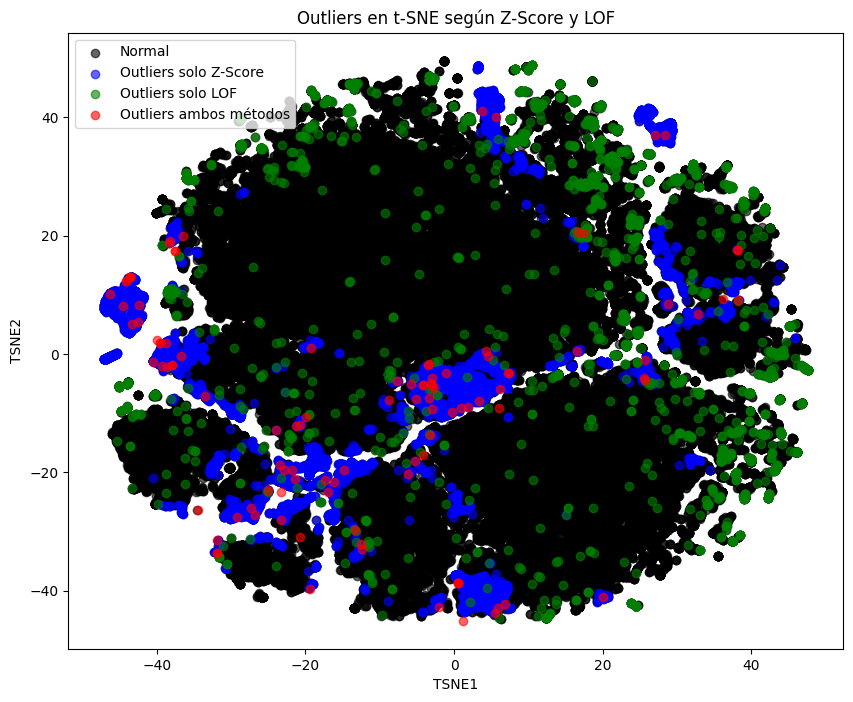

In [69]:
outliers_both = df[df['is_outlier_zscore'] & df['is_outlier_lofscore']]
outliers_only_z = df[(df['is_outlier_zscore'] & ~df['is_outlier_lofscore'])]
outliers_only_lof = df[(~df['is_outlier_zscore'] & df['is_outlier_lofscore'])]

# Mostrar los resultados
print(f"Instancias donde ambos métodos coinciden como outliers: {len(outliers_both)}")
print(f"Instancias que solo son outliers con Z-Score: {len(outliers_only_z)}")
print(f"Instancias que solo son outliers con LOF: {len(outliers_only_lof)}")

# Plotear los resultados en t-SNE
tsne_df['is_outlier_both']      = np.where( df['is_outlier_zscore'] & df['is_outlier_lofscore'], True, False)
tsne_df['is_outlier_only_z']    = np.where( df['is_outlier_zscore'] & ~df['is_outlier_lofscore'], True, False)
tsne_df['is_outlier_only_lof']  = np.where( ~df['is_outlier_zscore'] & df['is_outlier_lofscore'], True, False)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_df[~tsne_df['is_outlier_both']]['TSNE1'],      tsne_df[~tsne_df['is_outlier_both']]['TSNE2'],      alpha=0.6, label='Normal', c='black')               # Sin outliers en ambos
plt.scatter(tsne_df[tsne_df['is_outlier_only_z']]['TSNE1'],     tsne_df[tsne_df['is_outlier_only_z']]['TSNE2'],     alpha=0.6, label='Outliers solo Z-Score', c='blue') # Outliers detectados solo por Z-Score
plt.scatter(tsne_df[tsne_df['is_outlier_only_lof']]['TSNE1'],   tsne_df[tsne_df['is_outlier_only_lof']]['TSNE2'],   alpha=0.6, label='Outliers solo LOF', c='green')    # Outliers detectados solo por LOF
plt.scatter(tsne_df[tsne_df['is_outlier_both']]['TSNE1'],       tsne_df[tsne_df['is_outlier_both']]['TSNE2'],       alpha=0.6, label='Outliers ambos métodos', c='red') # Outliers detectados por ambos métodos (Z-Score y LOF)

plt.title("Outliers en t-SNE según Z-Score y LOF")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.legend()
plt.show()


A pesar de este análisis, es complicado sacar en claro si es mejor eliminar o mantener los outliers detectados. No es sencillo determinar si una canción no se corresponde al género para el que está etiquetada o si es por el hecho de compartir características con otras canciones. Por esta razón, se ha decidido mantener los outliers en el dataset ya que pueden aportar información al clasificador sobre los 'límites' de los géneros musicales.

# Entrenamiento

Se va a emplear __GridSearch__ para determinar los parámetros óptimos del modelo. GridSearch es una técnica de búsqueda exhaustiva de hiperparámetros en la que se define un conjunto de posibles valores para cada parámetro del modelo, y luego el algoritmo prueba todas las combinaciones posibles de esos valores. Al evaluar todas las combinaciones, GridSearch selecciona el conjunto de parámetros que produce el mejor rendimiento según una métrica predefinida, como la precisión o el F1-score.

Sin embargo, antes de comenzar se va a realizar un split para generar un conjunto de test en el cual se podrán comparar los distintos modelos.

In [7]:
# Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [8]:
def show_evaluation_report(model):
    y_pred = model.predict(X_test)
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    print(f"\nF1-Score en el conjunto de prueba:")
    print(f1_score(y_test, y_pred))


def show_preccision_recall(model):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Graficar la curva de precisión-recall
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision[:-1], label='Precisión')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Umbral de Decisión')
    plt.ylabel('Puntuación')
    plt.title('Curva de Precisión-Recall')
    plt.legend()
    plt.show()

def show_ROC_curve(models:List[tuple], ax:Axes = None):
    """
    models: [(model1, "desc1"), (model2, "desc2")...]
    """
    plt.figure(figsize=(5, 5))

    # Diagonal
    if ax is not None:
        ax.plot([0, 1], [0, 1], 'k--')
    else:
        plt.plot([0, 1], [0, 1], 'k--')
    
    # Curves
    for model, desc in models:
        # Calcular la curva ROC
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)

        # Graficar la curva ROC
        if ax is not None:
            ax.plot(fpr, tpr, label=f'{desc} (AUC = {auc_score:.2f})')
        else:
            plt.plot(fpr, tpr, label=f'{desc} (AUC = {auc_score:.2f})')
    
    if ax is not None:
        ax.set_title('Curva ROC')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc="lower right")
    else:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Curva ROC')
        plt.legend(loc="lower right")
        plt.show()

## XGBoostClassifier

**XGBoost (Extreme Gradient Boosting)** es un algoritmo basado en el principio de boosting, que combina múltiples modelos débiles (típicamente árboles de decisión) para formar un modelo fuerte. La idea básica de boosting es entrenar modelos secuenciales, donde cada nuevo modelo se entrena para corregir los errores cometidos por el modelo anterior. En XGBoost, el entrenamiento se realiza de manera iterativa y cada nuevo árbol ajusta los errores de los árboles previos, utilizando el gradiente de la función de pérdida para minimizar el error global.

XGBoost utiliza un enfoque de árboles de decisión en forma de "boosting" con regularización (para evitar el sobreajuste) y permite un control detallado de los parámetros, como la profundidad del árbol, el número de árboles y la tasa de aprendizaje, entre otros. Uno de los aspectos más relevantes de XGBoost es su capacidad para manejar datos desbalanceados, ya que permite asignar pesos a las clases para que el modelo preste más atención a las clases con menos ejemplos, mejorando así la predicción de la clase minoritaria.

Además de la regularización y el ajuste de pesos en las clases, XGBoost también permite asignar pesos a las clases para dar más importancia a la clase minoritaria durante el entrenamiento y el ajuste de la tasa de aprendizaje para evitar el sobreajuste y mejorar la capacidad de generalización del modelo.

A continuación, se va a realizar un entrenamiento del modelo utilizando el conjunto `['X_train', 'y_train']` mediante GridSearch. El objetivo establecer un _base-line_ para el modelo y determinar el rendimiento básico que se puede esperar de XGBoost sin aplicar técnicas adicionales.

In [9]:
def train_xgboost_model(model_name:str, X_train, y_train):
    
    model_path = os.path.join(os.getcwd(), f"{model_name}.pkl")
    if os.path.exists(model_path):
        model = joblib.load(model_path)
        best_params = None

        if model_name.find("baseline") != -1:
            best_params = {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 10, 'subsample': 0.8}
        if model_name.find("smote"):
            best_params = {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 10, 'subsample': 0.8}
        if model_name.find("under"):
            best_params = {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 15, 'subsample': 0.8}
        return model, best_params

    print("Haciendo GridSearch")
    # Definir el espacio de búsqueda de hiperparámetros
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'scale_pos_weight': [10, 15, 20]
    }
    # Modelo base de XGBoost
    model = XGBClassifier(random_state=42, eval_metric='logloss')
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    # Entrenar GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best model found
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_path)
    
    return best_model, grid_search.best_params_ 

print(f"Ratio teórico de desbalanceo: {(y_train == 0).sum() / (y_train == 1).sum()}")
xgboost_baseline_model, xgboost_baseline_params = train_xgboost_model("xgboost_baseline_model", X_train, y_train)

print("Hyperparámetros utilizados: ")
print(xgboost_baseline_params)

show_evaluation_report(xgboost_baseline_model)

Ratio teórico de desbalanceo: 15.285714285714286
Hyperparámetros utilizados: 
{'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 15, 'subsample': 0.8}
Matriz de Confusión:
[[30909  1191]
 [  549  1551]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     32100
           1       0.57      0.74      0.64      2100

    accuracy                           0.95     34200
   macro avg       0.77      0.85      0.81     34200
weighted avg       0.96      0.95      0.95     34200


F1-Score en el conjunto de prueba:
0.6406443618339529


El modelo muestra un rendimiento desbalanceado debido a la naturaleza del dataset, en el que la clase mayoritaria (canciones que no pertenecen al conjunto `'metal'`) tiene un rendimiento mucho mejor que la clase minoritaria. En la matriz de confusión, se observa que el modelo predice correctamente la mayoría de las instancias de la clase $0$ ($30909$) pero falla más frecuentemente al predecir la clase $1$ ($549$ falsos negativos). A pesar de obtener una alta precisión y recall en la clase mayoritaria, la clase minoritaria presenta un rendimiento considerablemente más bajo, con una precisión de $0.57$ y un recall de $0.74$. El F1-score de la clase minoritaria es de $0.64$, lo que refleja un compromiso entre precisión y recall, pero aún muestra que el modelo no está optimizado para esta clase. Aunque la precisión global del modelo es alta ($0.95$), el desbalance en las clases afecta significativamente su capacidad para identificar correctamente las instancias de la clase minoritaria.

Pese a todo ello, se va a emplear este modelo como _base-line_ para futuros entrenamientos, en los que se van a explorar las técnicas de _Oversampling_ y _Undersampling_.

En estos entrenamientos se van a utilizar los hiperparámetros determinados en el _base-line_:
- **colsample_bytree**: 0.8
- **gamma**: 0
- **learning_rate**: 0.1
- **max_depth**: 7
- **n_estimators**: 300
- **scale_pos_weight**: 10
- **subsample**: 0.8


### SMOTE (Oversampling)

**SMOTE (Synthetic Minority Over-sampling Technique)** es una técnica de *oversampling* que genera muestras sintéticas de la clase minoritaria al interpolar entre puntos cercanos. La intención es aplicar esta técnia al conjunto de entrenamiento y realizar una validación cruzada estratificada para comprobar si se obtienen mejores resultados.

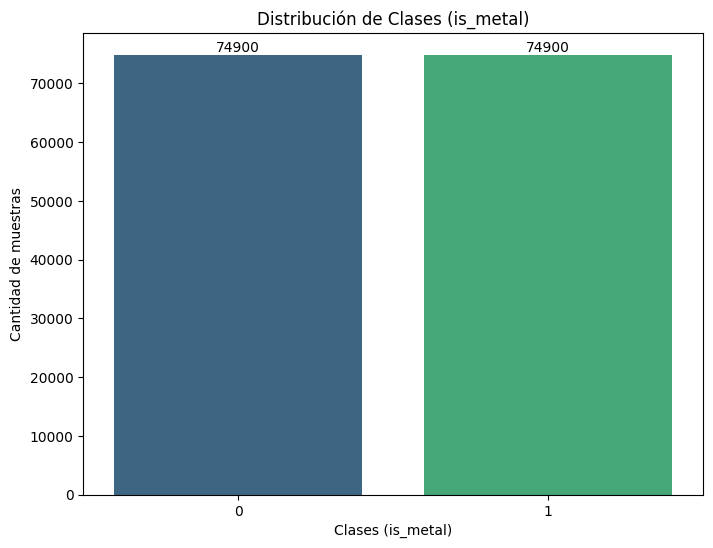

In [13]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
plot_class_counts(y_train_resampled)

In [14]:
xgboost_smote_model, best_smote_params = train_xgboost_model("xgboost_smote_model", X_train_resampled, y_train_resampled)

print("Hyperparámetros utilizados: ")
print(best_smote_params)

show_evaluation_report(xgboost_baseline_model)

Hyperparámetros utilizados: 
{'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 15, 'subsample': 0.8}
Matriz de Confusión:
[[30909  1191]
 [  549  1551]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     32100
           1       0.57      0.74      0.64      2100

    accuracy                           0.95     34200
   macro avg       0.77      0.85      0.81     34200
weighted avg       0.96      0.95      0.95     34200


F1-Score en el conjunto de prueba:
0.6406443618339529


A pesar de haber entrenado el mo utilizando SMOTE para generar datos sintéticos balanceados, las métricas globales no muestran una diferencia significativa respecto al modelo entrenado con los datos originales. Esto puede indicar, al menos términos generales, el uso de SMOTE no ha mejorado sustancialmente el rendimiento del modelo. Por ello, se va a probar el _undersampling_ como otro método de balanceo de clases. 

### Undersampling

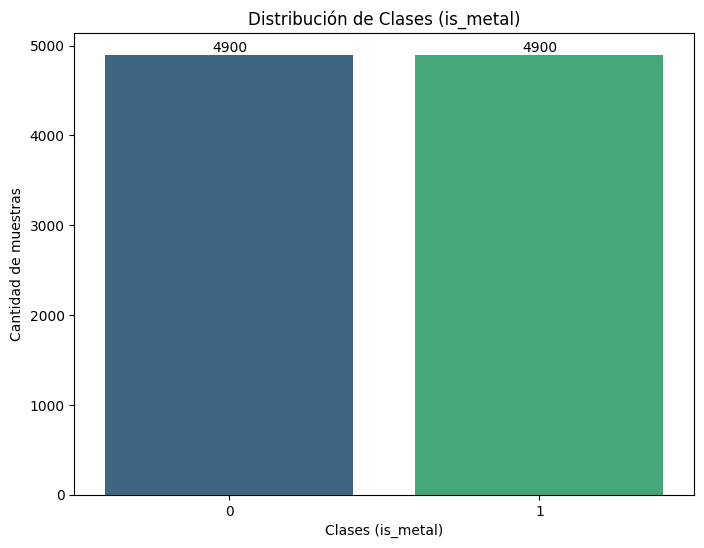

In [15]:
undersample = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)
plot_class_counts(y_train_resampled)

In [16]:
xgboost_under_model, best_under_params = train_xgboost_model("xgboost_under_model", X_train_resampled, y_train_resampled)

print("Hyperparámetros utilizados: ")
print(best_under_params)

show_evaluation_report(xgboost_under_model)

Hyperparámetros utilizados: 
{'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 15, 'subsample': 0.8}
Matriz de Confusión:
[[26865  5235]
 [  146  1954]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91     32100
           1       0.27      0.93      0.42      2100

    accuracy                           0.84     34200
   macro avg       0.63      0.88      0.66     34200
weighted avg       0.95      0.84      0.88     34200


F1-Score en el conjunto de prueba:
0.4207126709010658


Haciendo _Undersampling_, tanto la precisión y recall como el f1-score bajan considerablemente respecto a SMOT y al _base-line_.

## RandomForest

**Random Forest** es un algoritmo supervisado que combina múltiples árboles de decisión mediante **bagging**, generando subconjuntos de datos con muestreo con reemplazo y seleccionando aleatoriamente características en cada nodo para reducir el sobreajuste. La predicción de este modelo combina las respuestas de todos los árboles y emplea la clase con más votos. Es robusto y maneja bien datos ruidosos, aunque su alto costo computacional y menor interpretabilidad pueden ser desventajas.  

A diferencia de **XGBoost**, que construye los árboles secuencialmente mediante **boosting**, Random Forest los crea en paralelo, por lo que puede ser interesante ver la comparativa de estos dos modelos frente al conjunto de datos de estudio.

Se va a realizar un entrenamiento de un modelo sobre todo el conjunto `['X_train', 'y_train']` empleando GridSearch y no se han considerado las técnicas de _sampling_ debido a que durante los entrenamientos de XGBoost han mostrado indicios de empeorar el modelo inicial. 

In [55]:
def train_forest_model(model_name):
    model_path = os.path.join(os.getcwd(), f"{model_name}.pkl")
    if os.path.exists(model_path):
        print("Cargando modelo entrenado...")
        model = joblib.load(model_path)
        best_params = None

        if model_name.find("baseline") != -1:
            best_params = {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 300, 'class_weights': {0: 1, 1: 10}  }
        return model, best_params

    print("Haciendo GridSearch...")

    # Definir el espacio de búsqueda de hiperparámetros
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'class_weights': [{0: 1, 1: 10}]
    }

    model = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(
        estimator=model, 
        param_grid=param_grid, 
        cv=5, 
        scoring='f1')

    # Entrenar GridSearchCV
    grid_search.fit(X_train, y_train)

    # Best model found
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, model_path)

    return best_model, grid_search.best_params_ 
    
forest_baseline_model, forest_baseline_params = train_forest_model("forest_baseline_model")
print("Hyperparámetros utilizados: ")
show_evaluation_report(forest_baseline_model)

Haciendo GridSearch...
Mejores parámetros encontrados: 
{'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 300}
Matriz de Confusión:
[[31307   793]
 [  758  1342]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     32100
           1       0.63      0.64      0.63      2100

    accuracy                           0.95     34200
   macro avg       0.80      0.81      0.80     34200
weighted avg       0.96      0.95      0.95     34200


F1-Score en el conjunto de prueba:
0.6337662337662338


Como se puede apreciar, a primera vista son unos resultados muy similares a los obtenidos con XGBoost y se muestra un rendimiento desbalanceado.

# Comparación de modelos

Dado que ambos modelos se evalúan en el mismo conjunto de prueba (X_test, y_test), los resultados son datos pareados. Esto significa que las predicciones de ambos modelos están relacionadas, ya que se basan en las mismas muestras de prueba. Esta prueba compara las medias de dos grupos relacionados (en este caso, las predicciones de los dos modelos).

Para comparar estadísticamente los dos modelos, suele ser una opción común utilizar la prueba t de Student para muestras pareadas o la prueba de Wilcoxon (no paramétrica). En este caso y debido a que los datos no siguen una distribución normal (comprobado en la sección de exploración de datos), se ha optado por la prueba de Wilcoxon.

In [113]:
# Selección de modelos a comparar
xgb_model   = xgboost_baseline_model
rf_model    = forest_baseline_model

In [136]:
# Predecir con XGBoostClassifier
y_pred_xgb = xgb_model.predict(X_test)

# Predecir con RandomForest
y_pred_rf = rf_model.predict(X_test)


# Prueba de Wilcoxon
w_stat, p_value = wilcoxon(y_pred_xgb, y_pred_rf) 
print(f"[Wilcoxon] Estadístico: {w_stat} p-valor: {p_value}")
if p_value < 0.05:
    print("[Wilcoxon] Hay una diferencia estadísticamente significativa entre los modelos.")
else:
    print("[Wilcoxon] No hay una diferencia estadísticamente significativa entre los modelos.")
print()

# Prueba de McNemar
conf_matrix = confusion_matrix(y_pred_xgb, y_pred_rf)
result = mcnemar(conf_matrix, exact=True) 
print(f"[McNemar] p-valor: {result.pvalue:.4f}")
if result.pvalue < 0.05:
    print("[McNemar] Diferencia significativa entre los modelos.")
else:
    print("[McNemar] No hay diferencia significativa entre los modelos.")
print()

# Otras métricas
xgb_kappa   = cohen_kappa_score(y_test, y_pred_xgb)
xgb_f1      = f1_score(y_test, y_pred_xgb)
print(f"[XGBoost] F1-Score: {xgb_f1} Kappa: {xgb_kappa}")

rf_kappa    = cohen_kappa_score(y_test, y_pred_rf)
rf_f1       = f1_score(y_test, y_pred_rf)
print(f"[RandomForest] F1-Score: {rf_f1} Kappa: {rf_kappa}")



[Wilcoxon] Estadístico: 23985.0 p-valor: 9.840716091779145e-111
[Wilcoxon] Hay una diferencia estadísticamente significativa entre los modelos.

[McNemar] p-valor: 0.0000
[McNemar] Diferencia significativa entre los modelos.

[XGBoost] F1-Score: 0.6406443618339529 Kappa: 0.6137850467289719
[RandomForest] F1-Score: 0.6337662337662338 Kappa: 0.6095959372930007


El valor $p = 9.84 \times 10^{-111}$ es extremadamente pequeño, lo que indica una diferencia estadísticamente significativa entre los dos modelos. Esto sugiere que las predicciones de XGBoost y Random Forest no son similares y que al menos uno de los modelos tiene un comportamiento diferente en la clasificación. 

Este hecho se puede comprobar con la curva ROC de la siguiente gráfica en la que a pesar de que en términos globales las curvas sean muy parecidas, existen pequeñas perturbaciones que las diferencian.

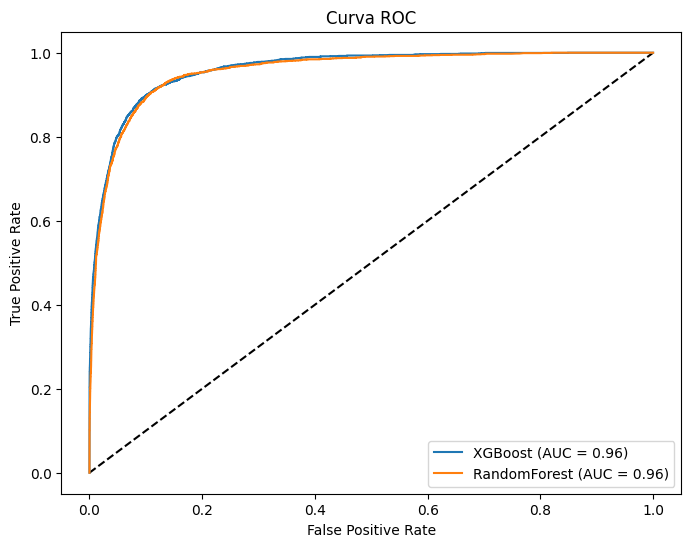

In [139]:
show_ROC_curve([(xgb_model, "XGBoost"), (rf_model, "RandomForest")])

Las pruebas estadísticas de McNemar y Wilcoxon indican una diferencia estadísticamente significativa, pero la curva ROC-AUC y las métricas F1 y Kappa muestran resultados similares. Esto implica que aunque los modelos tienen un rendimiento global parecido en términos de discriminación, sus errores de clasificación son distintos. Es decir, las instancias en las que fallan los modelos son distintas.

En este punto, cabría estudiar las diferencias entre los errores de predicción de los dos modelos con el fin de determinar cuál de los dos es más adecuado para el caso de uso. 

# Conclusiones

El problema de clasificación de géneros musicales en base a variables tabulares es un problema complejo. Muchos géneros de canciones comparten características y en ocasiones no resulta tribial su diferenciación. De la misma manera, las canciones pueden estar etiquetadas con un género musical pero compartir muchas características de otros géneros.  Esto se ha visto reflejado tanto en las visualizaciones del dataset utilizando PCA y t-SNE, como con las agrupaciones y estimaciones de distribuciones de las features del conjunto de datos.

Además, al entrenar los modelos de XGBoost, no se han recogido diferencias significativas entre los distintos modelos al aplicar técnicas de _Oversampling_ y _Undersampling_, lo cual sí que resulta chocante ya que esto sugiere que el modelo ya estaba manejando bien la distribución de clases. Es por esta razón que se ha decido entrenar un único modelo de Random Forest empleando la misma técnica para el modelo base de XGBoost y tampoco se han encontrado diferencias significativas de rendimiento global entre los dos modelos, aunque sí que se han detectado diferencias en los errores de predicción.

A pesar de estos desafíos, el modelo sigue teniendo un rendimiento estable, y las métricas de evaluación continúan siendo satisfactorias. Sin embargo, se sugiere explorar otras técnicas de modelado o reducción de dimensionalidad que puedan ofrecer una representación más efectiva de las relaciones en los datos, ya que el modelo actual podría beneficiarse de ajustes más específicos.